In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torchvision
from sklearn.linear_model import LogisticRegression as lr
from sklearn.linear_model import LogisticRegressionCV as lrcv
from sklearn.calibration import CalibratedClassifierCV
from rankpruning import multiclass_rankpruning, generate_noise_matrix
import numpy as np
from PIL import Image

import sys
import os
import traceback
from datetime import datetime as dt

from sklearn.metrics import confusion_matrix, accuracy_score

# Important! Make fonts Type I fonts (necessary for publishing in ICML and other conference)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
from torchvision import datasets
X_train = datasets.MNIST('../data', train=True).train_data.numpy()
X_test = datasets.MNIST('../data', train=False).test_data.numpy()
y_train = datasets.MNIST('../data', train=True).train_labels.numpy()
y_test = datasets.MNIST('../data', train=False).test_labels.numpy()
py_train = multiclass_rankpruning.value_counts(y_train) / float(len(y_train))

## Finding label errors in MNIST training set

In [8]:
def softmax(x, beta = 1):
    """Compute softmax values for each sets of scores in x."""
    x = beta * x
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def imshow(inp, img_labels=None, img_pred=None, img_fns = None, figsize=(10,10), normalize=False, method_name = '', savefig = False):
    """Imshow for Tensor."""
    height, width = inp.shape[1:]
    xbins = 8
    ybins = int(np.ceil(len(img_labels)/xbins))
    xbin_width = width // xbins
    ybin_height = height // ybins
    
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    
    ax = plt.figure(figsize=figsize).gca()
    ax.imshow(inp)
    pad_size = (8-len(img_pred)%8)%8
    img_labels = img_labels + ['']*pad_size #padding
    img_pred = img_pred + ['']*pad_size #padding
    img_fns = img_fns + ['']*pad_size #padding
#     grid = np.asarray(img_labels).reshape((ybins, xbins))
        
    for (j,i),idx in np.ndenumerate(np.arange(ybins*xbins).reshape((ybins, xbins))):
        prediction = img_pred[idx]
        label = img_labels[idx]
        img_fn = img_fns[idx]
        image_index = int(img_fn[13:])
        
        plt.hlines([j*ybin_height - .5], xmin=i*xbin_width, xmax=i*xbin_width + xbin_width, color = 'lightgray', linewidth=2)
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(prediction)), 12) if prediction != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/20,prediction,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lime', alpha=0.8, edgecolor=None))
        
        fontsize=min(.5*figsize[0], 1.25*figsize[0]-len(img_fn)) if img_fn != '' else 1
        tt = ax.text(i*xbin_width + xbin_width/2.8,j*ybin_height + ybin_height/7,img_fn,ha='center',va='center', fontsize=fontsize)
        tt.set_bbox(dict(facecolor='lightgray', alpha=0.8, edgecolor=None))
        
        fontsize=max(min(1.4*figsize[0], .9*figsize[0]-.7*len(label)),12) if label != '' else 1
        t = ax.text(i*xbin_width + xbin_width/2,j*ybin_height + ybin_height/10*9,label,ha='center',va='center', fontsize=fontsize)
        t.set_bbox(dict(facecolor='cyan', alpha=0.8, edgecolor=None))
        
        if image_index in [21601, 40466, 29922, 40144, 51248, 43454, 59915, 57662, 25678, 2676, 24798, 31727, 7080, 26560, 10994, 53396, 54264]: # 26940, 47759, 59701, 42566, 22643, 56452, 26756, 1075, 10992:
            # Draw red bounding box
            plt.hlines([j*ybin_height + 0.5,(j+1)*ybin_height - 1.5], xmin=i*xbin_width - 0.3, xmax=i*xbin_width + xbin_width - 0.65, color = 'red', linewidth=15)
            plt.vlines([i*xbin_width + 0.5,(i+1)*xbin_width - 1.5], ymin=j*ybin_height + 0.5, ymax=j*ybin_height + ybin_height - 0.5, color = 'red', linewidth=15)
            
        
    plt.axis('off')
    if savefig:
        plt.savefig('figs/mnist_LOGREG_training_label_errors'+str(len(img_pred))+"_"+method_name+'.pdf', pad_inches=0.0, bbox_inches='tight')
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def make3d(img_arr):    
    return np.stack((img_arr,)*3, -1) if len(img_arr.shape) < 3 else img_arr

def sm(x):
    return torch.nn.functional.softmax(Variable(torch.from_numpy(x)), dim=0).data.numpy()

METHOD: prune_by_class


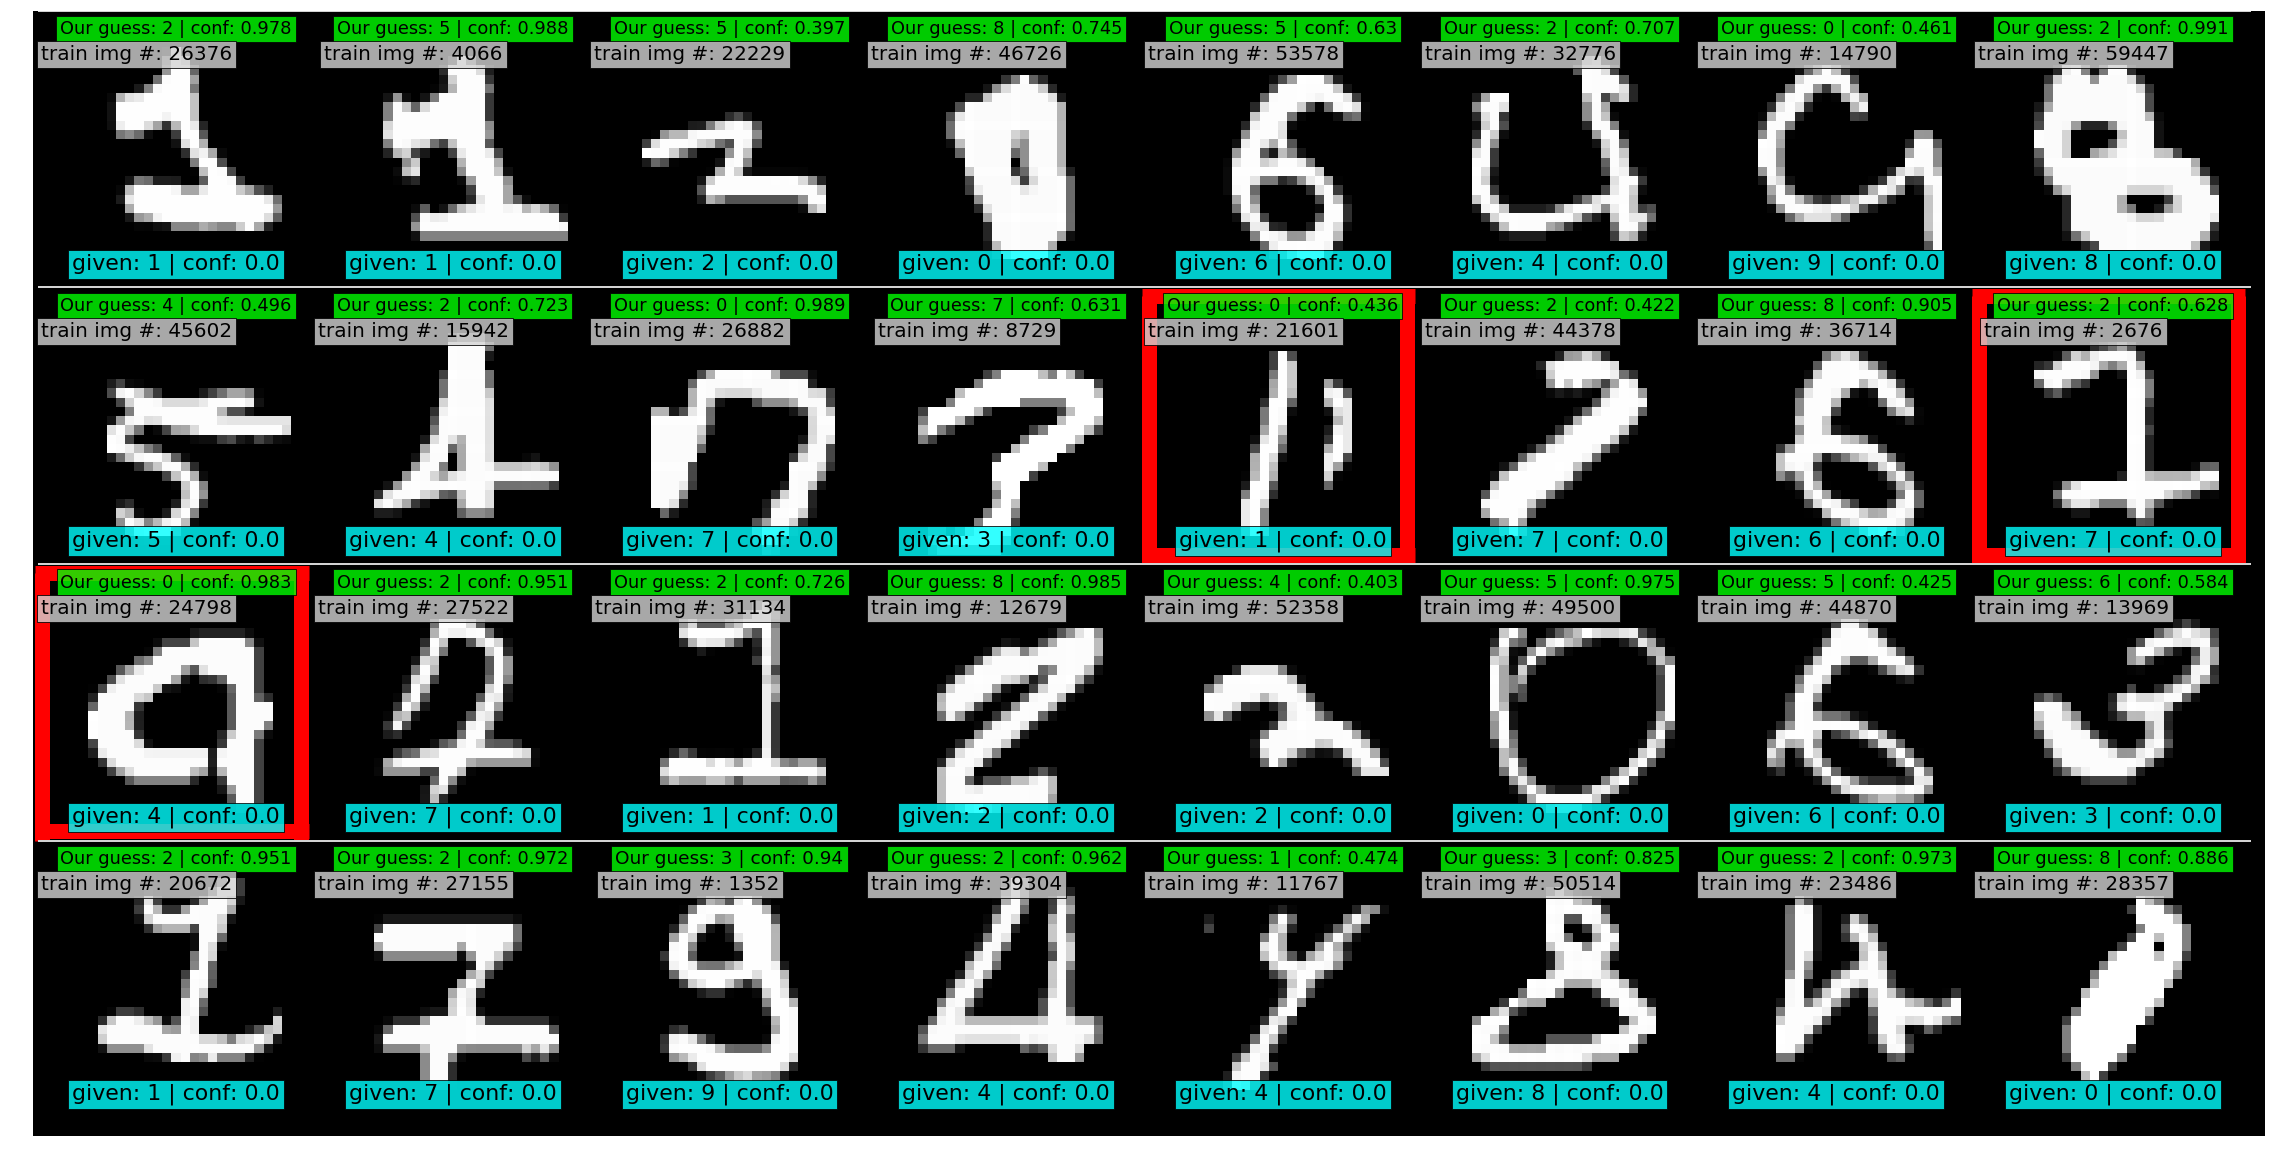

METHOD: prune_by_noise_rate


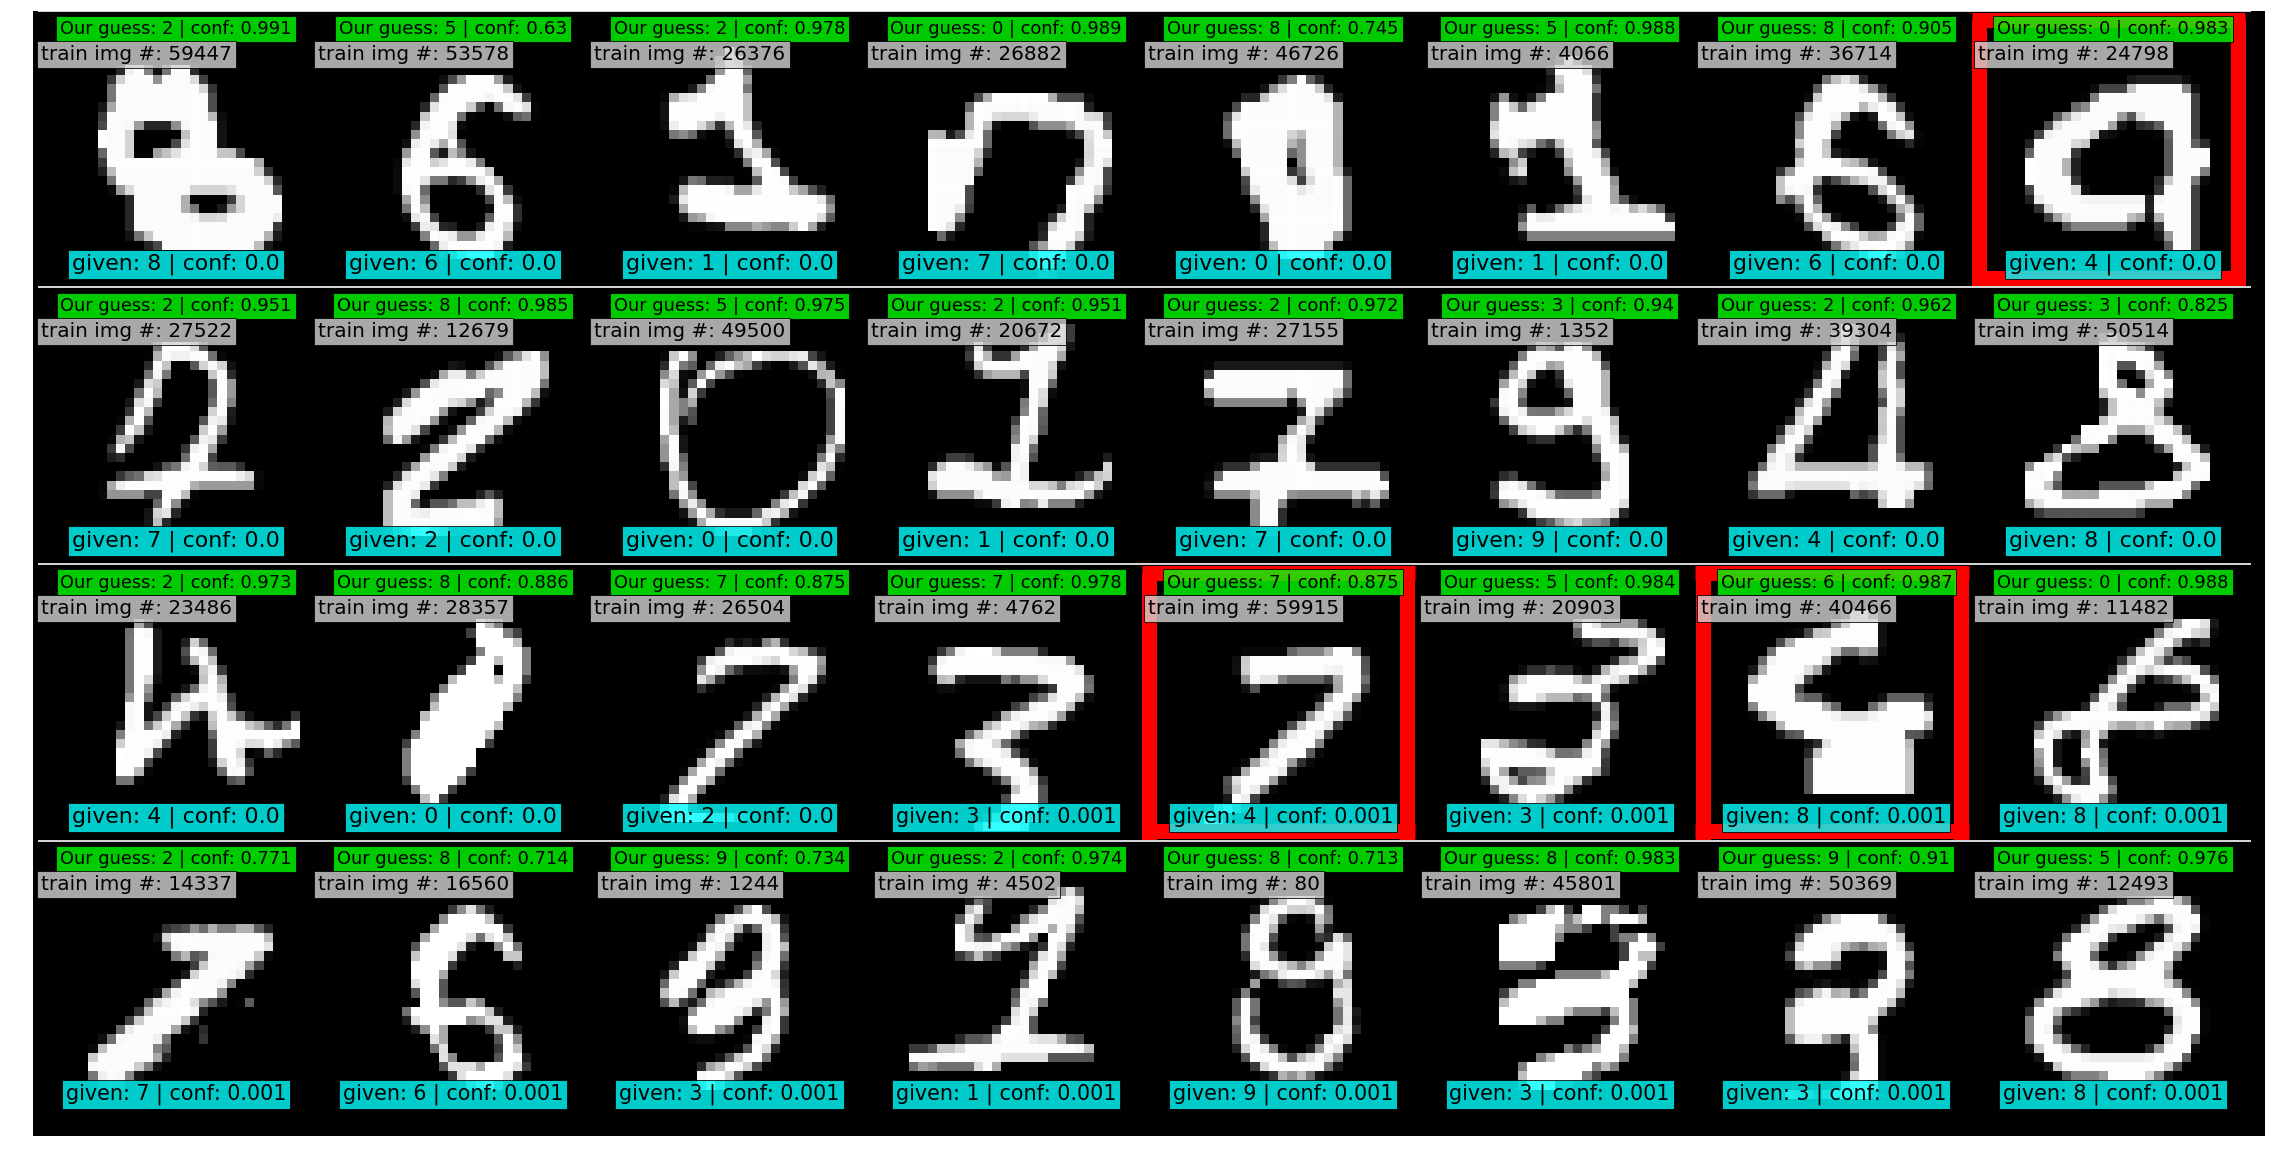

METHOD: both


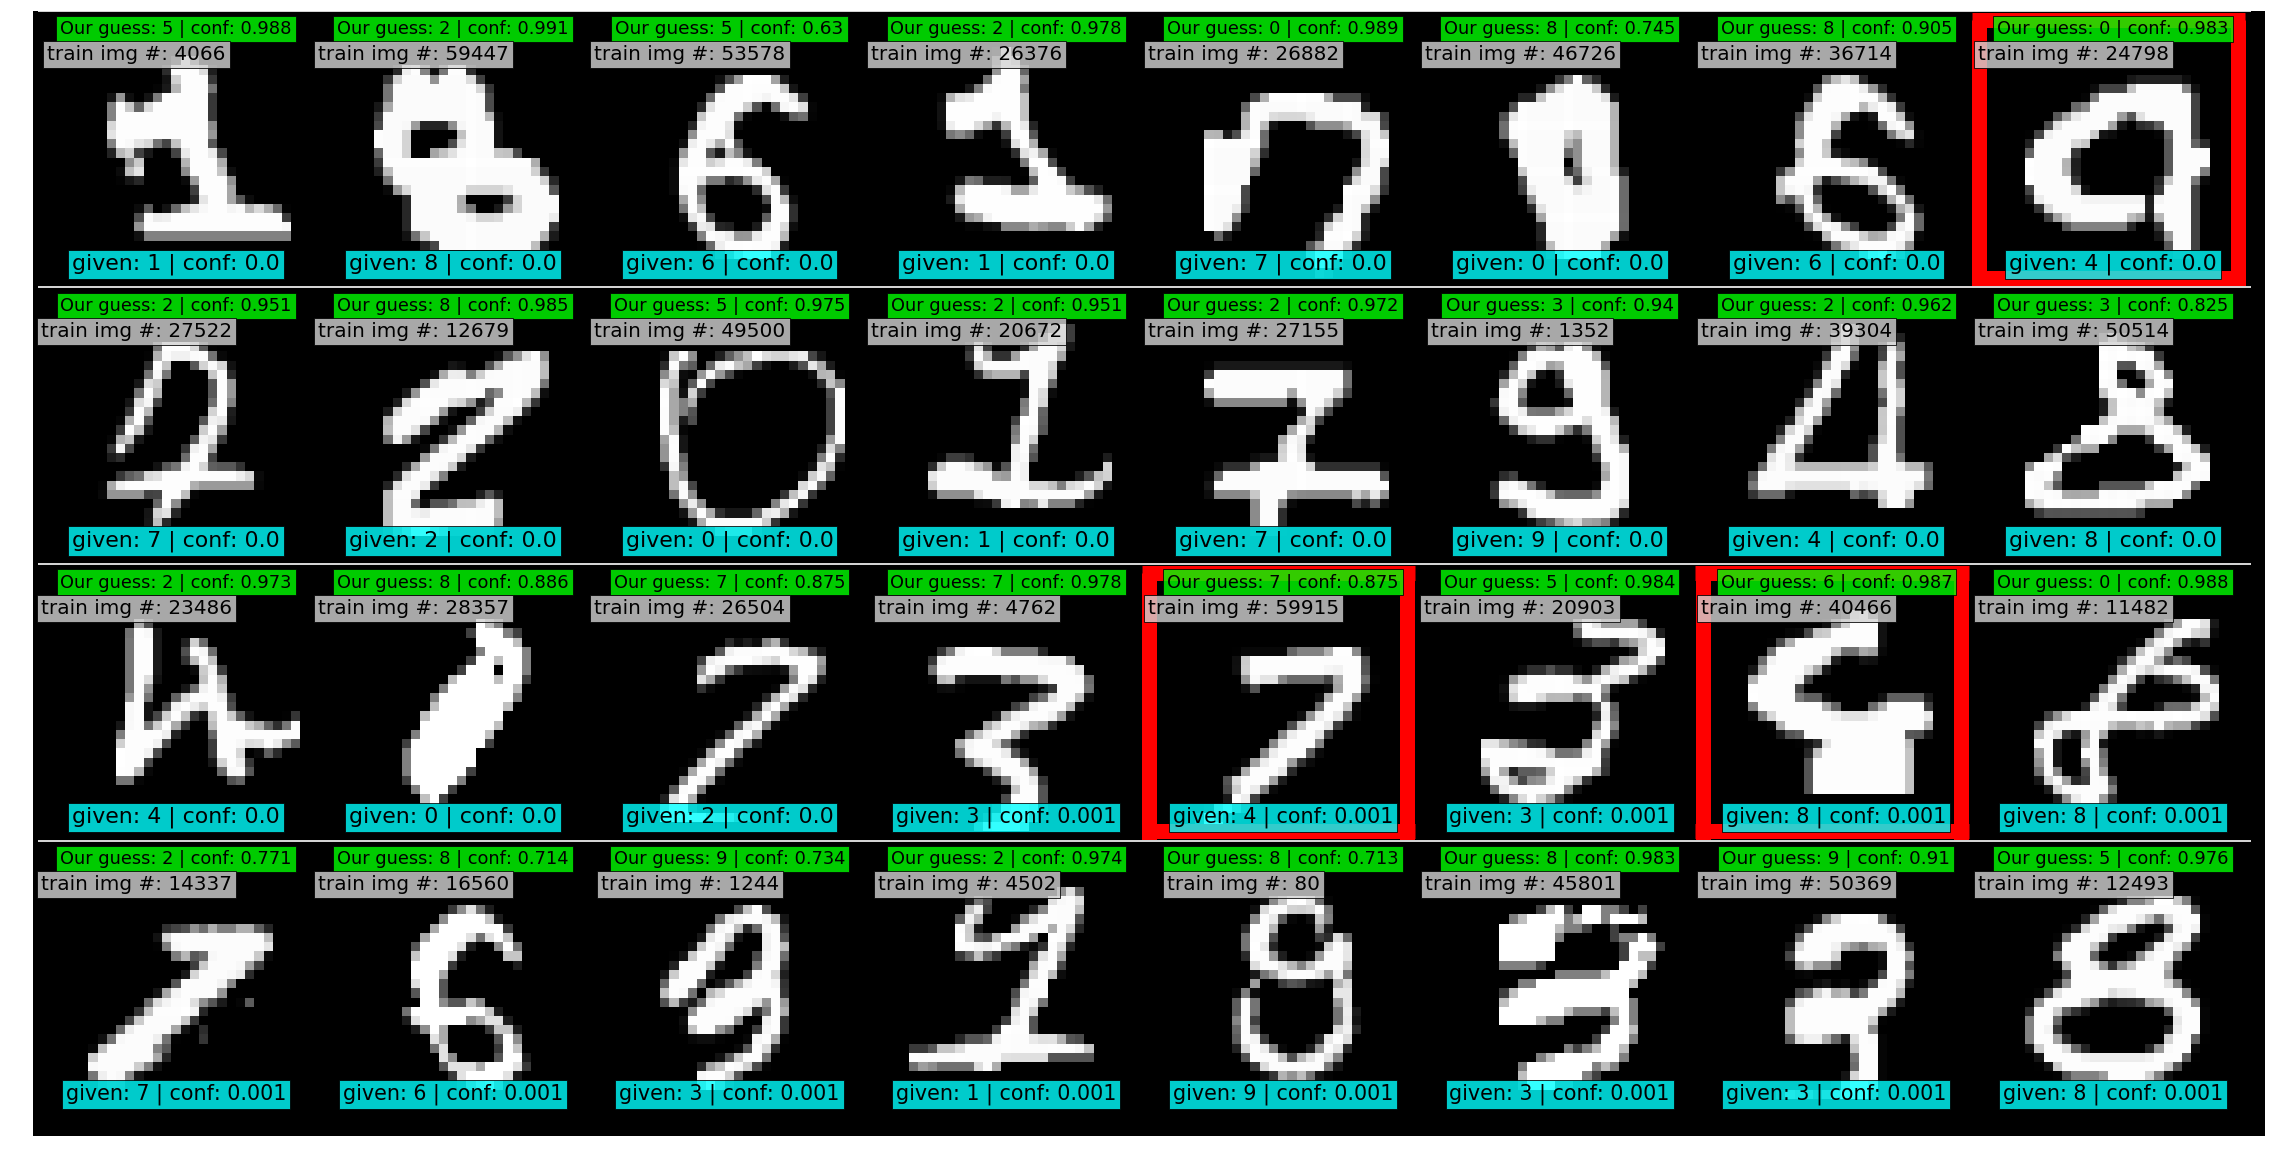

In [10]:
max_images = 32

clf = CalibratedClassifierCV(lr(tol=.01), method='isotonic', cv=5)
jc, psx = multiclass_rankpruning.estimate_joint_counts_and_cv_pred_proba(
    X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), # Make MNIST (60000, 784)
    y_train, 
    clf=clf, 
)
est_py, est_nm, est_inv = multiclass_rankpruning.estimate_latent(jc, y_train)

for method in ['prune_by_class', 'prune_by_noise_rate', 'both']:
    print('METHOD:', method)
    
    noise_idx = multiclass_rankpruning.get_noise_indices(y_train, psx, est_inv, method=method, joint_count=jc)
    pred = np.argmax(psx, axis=1)
    # ordered_noise_idx = np.argsort(np.asarray([psx[idx,y_train[idx]] - psx[idx,pred[idx]] for idx in range(len(y_train)) ])[noise_idx])
    ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])
    
    prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
    prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
    img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
    label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
    pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

    graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_train[img_idx][:, None]]*3, axis=1)))
    # graphic = np.concatenate([graphic[:, None]]*3, axis=1)
    img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
    img_pred = ["Our guess: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
    img_fns = ["train img #: " + str(item) for item in img_idx]

    imshow(graphic, img_labels = img_labels, img_pred = img_pred, img_fns = img_fns, figsize=(40,max_images/1.1), method_name = method, savefig = True)


TOLERANCE 10 METHOD: prune_by_class


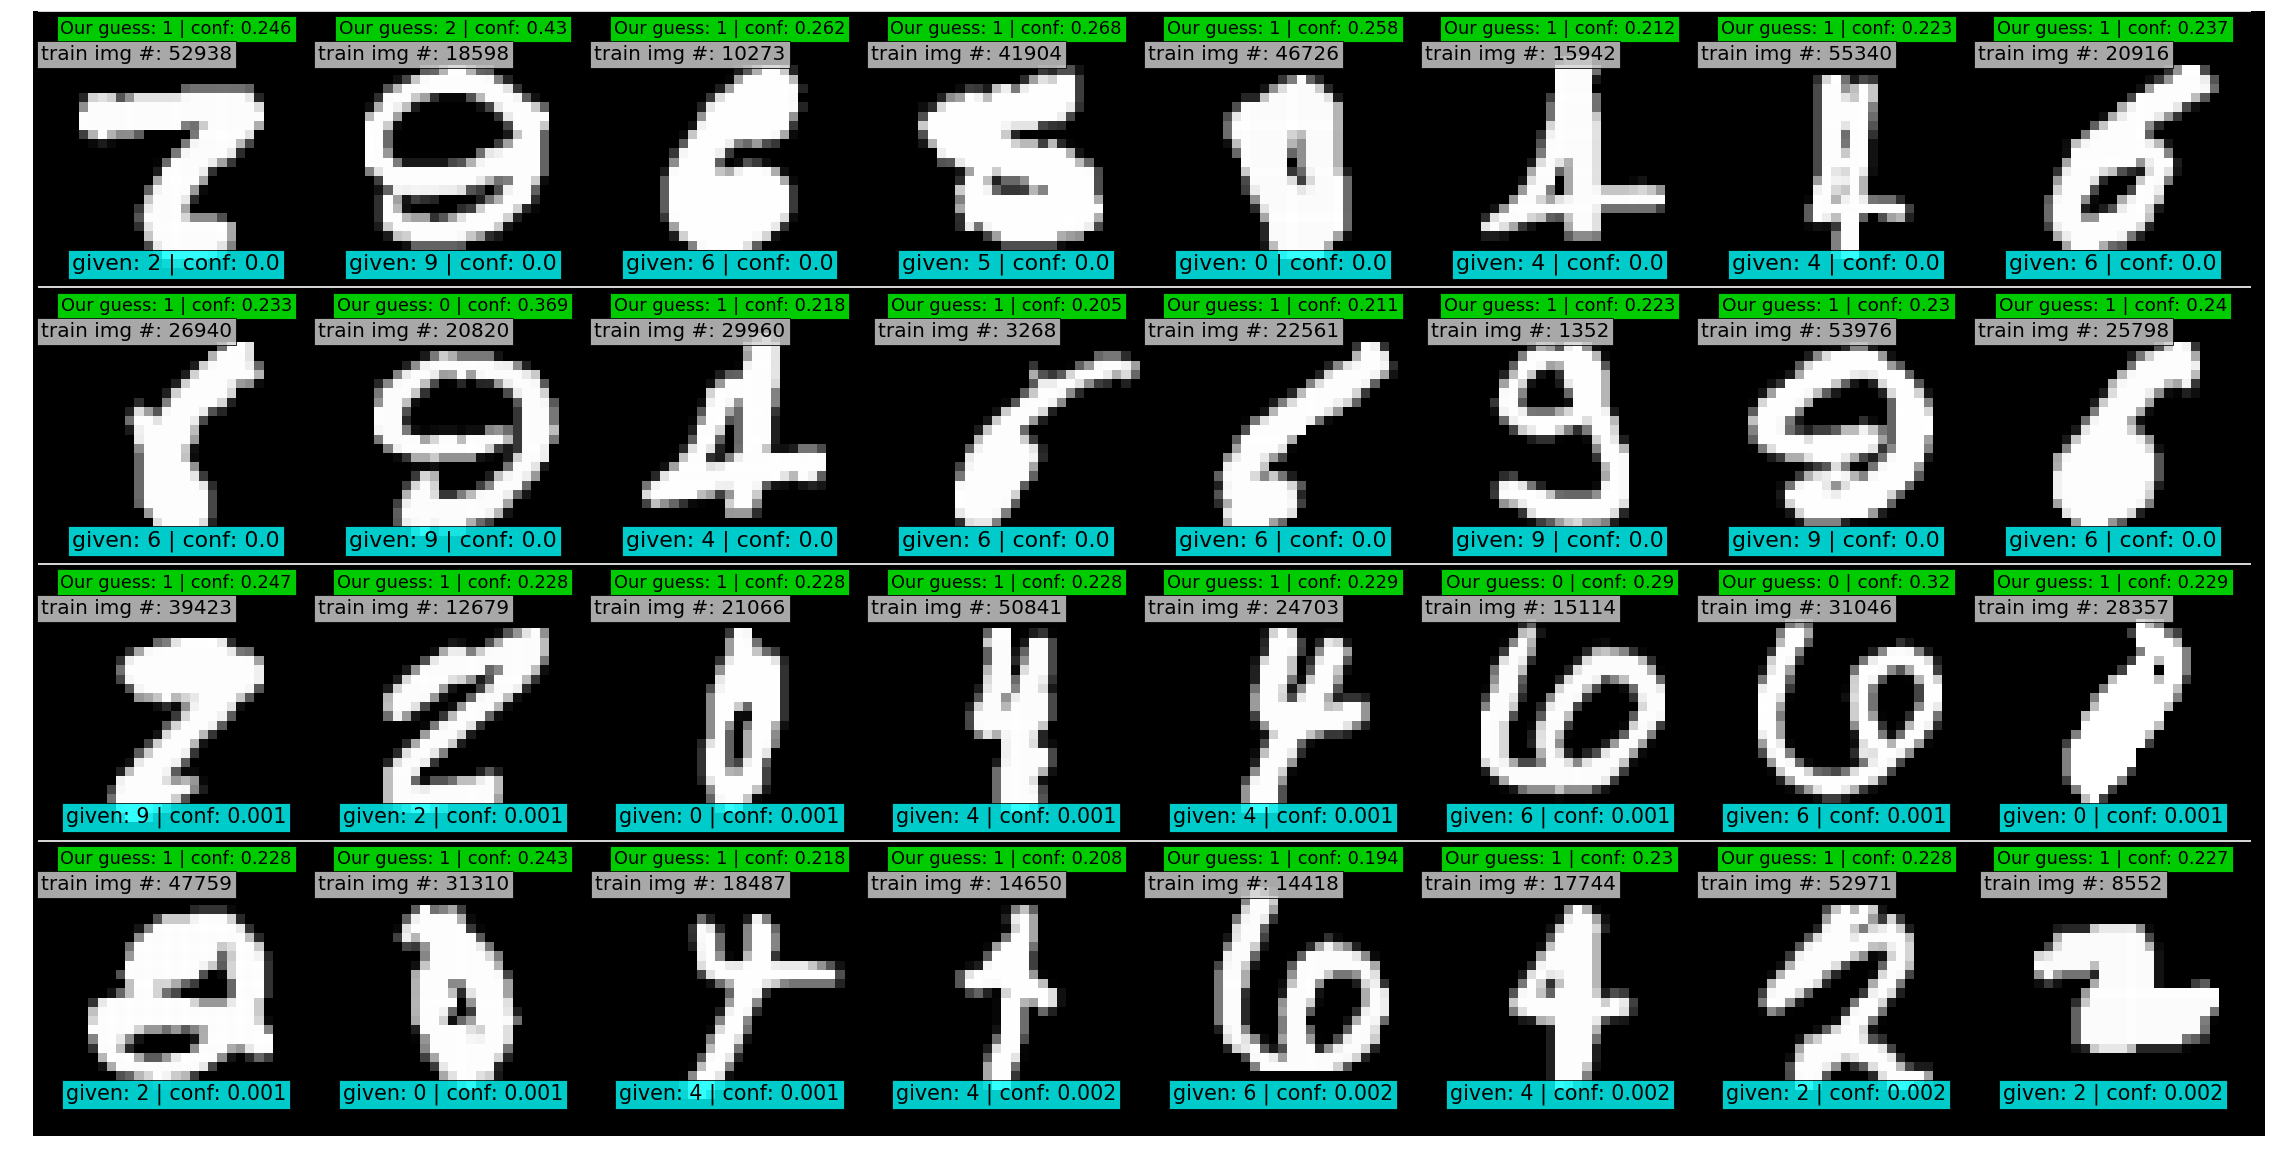

TOLERANCE 10 METHOD: prune_by_noise_rate


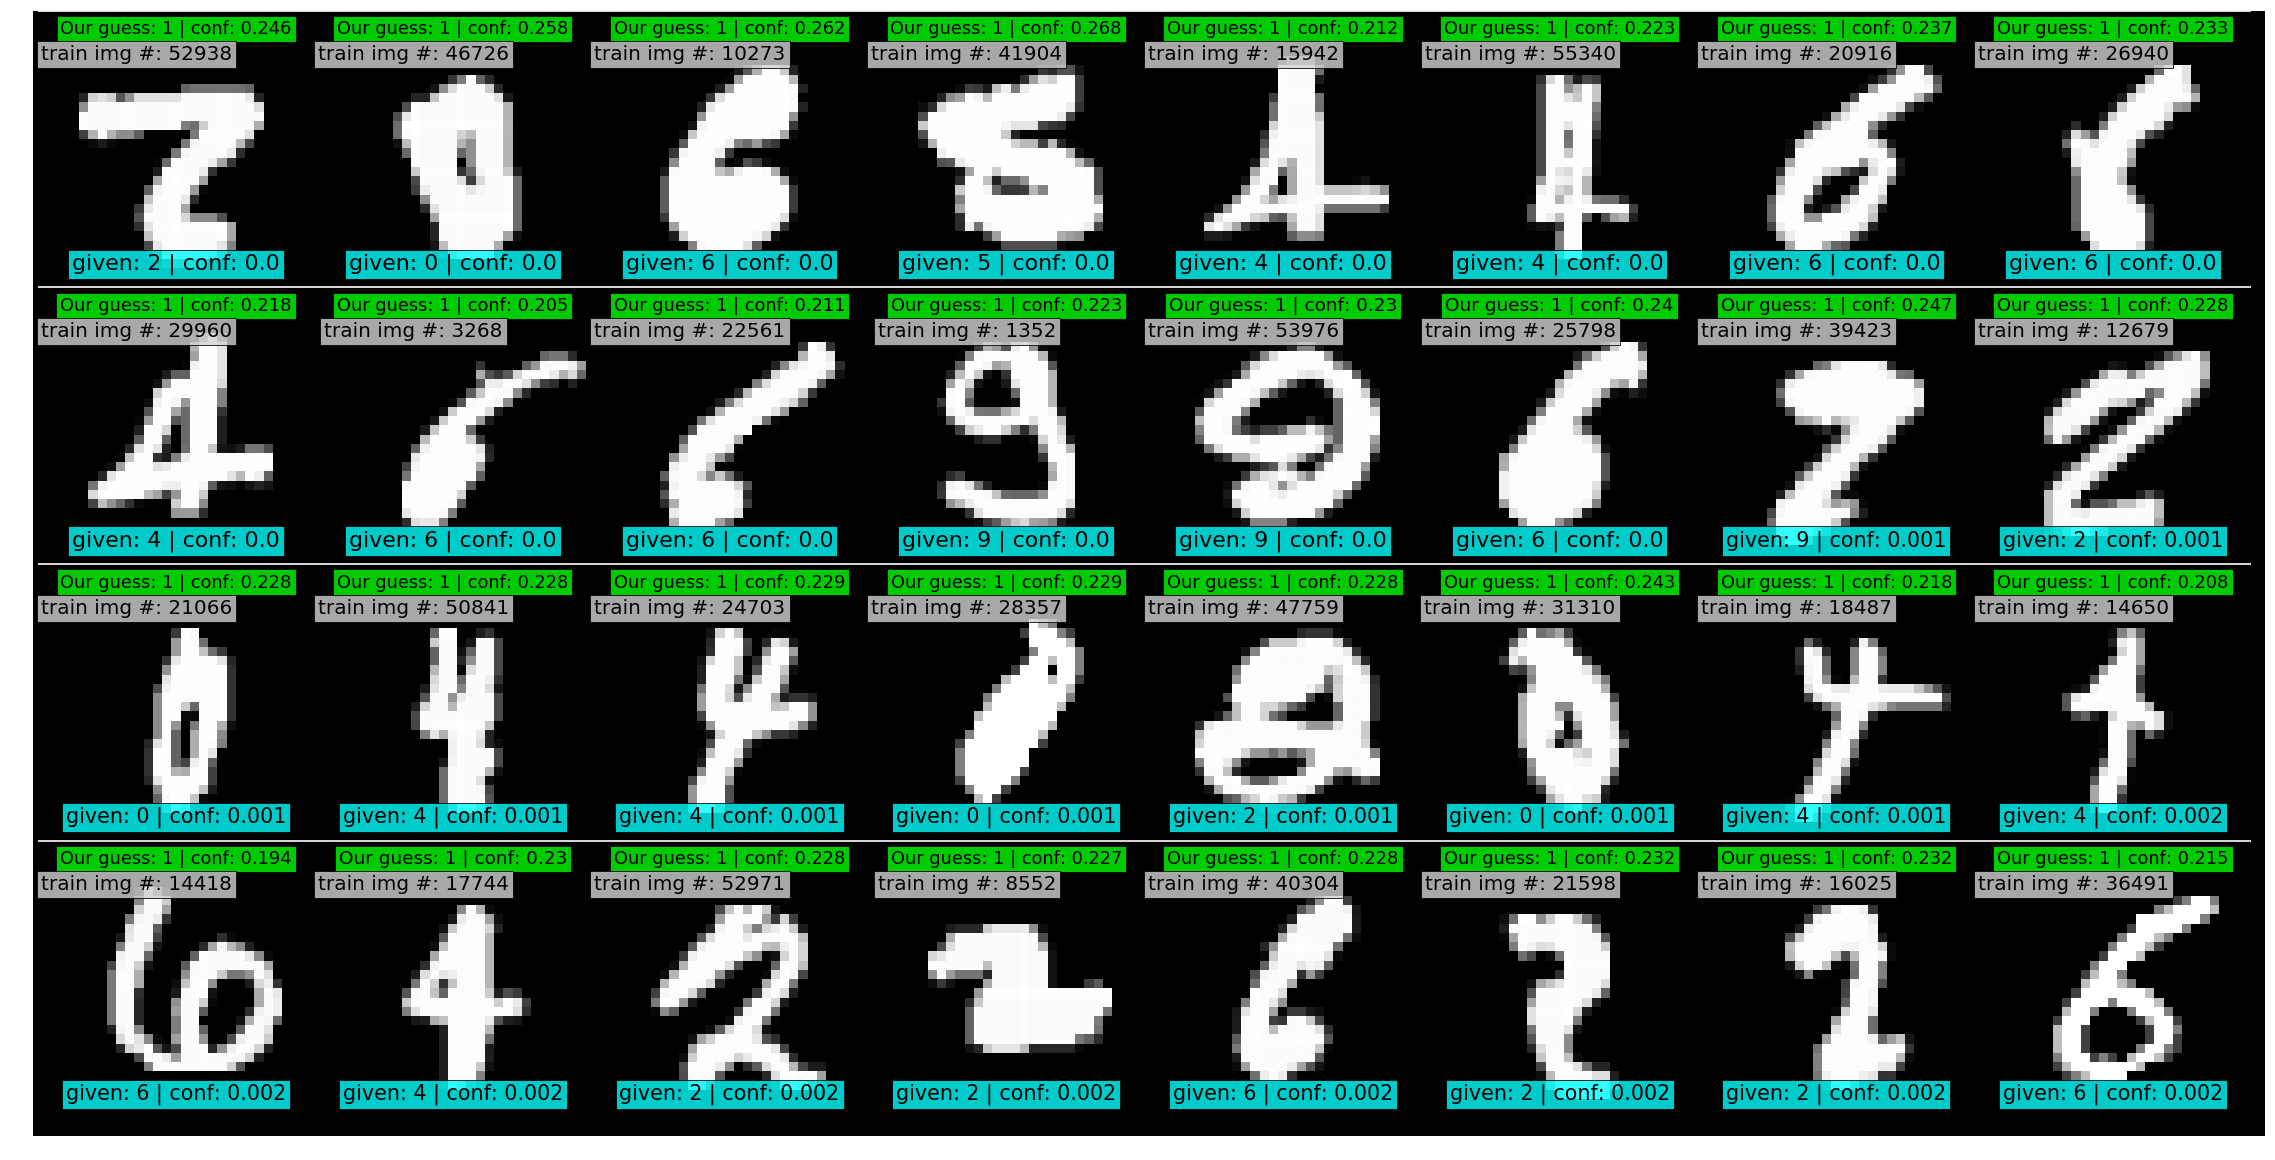

TOLERANCE 10 METHOD: both


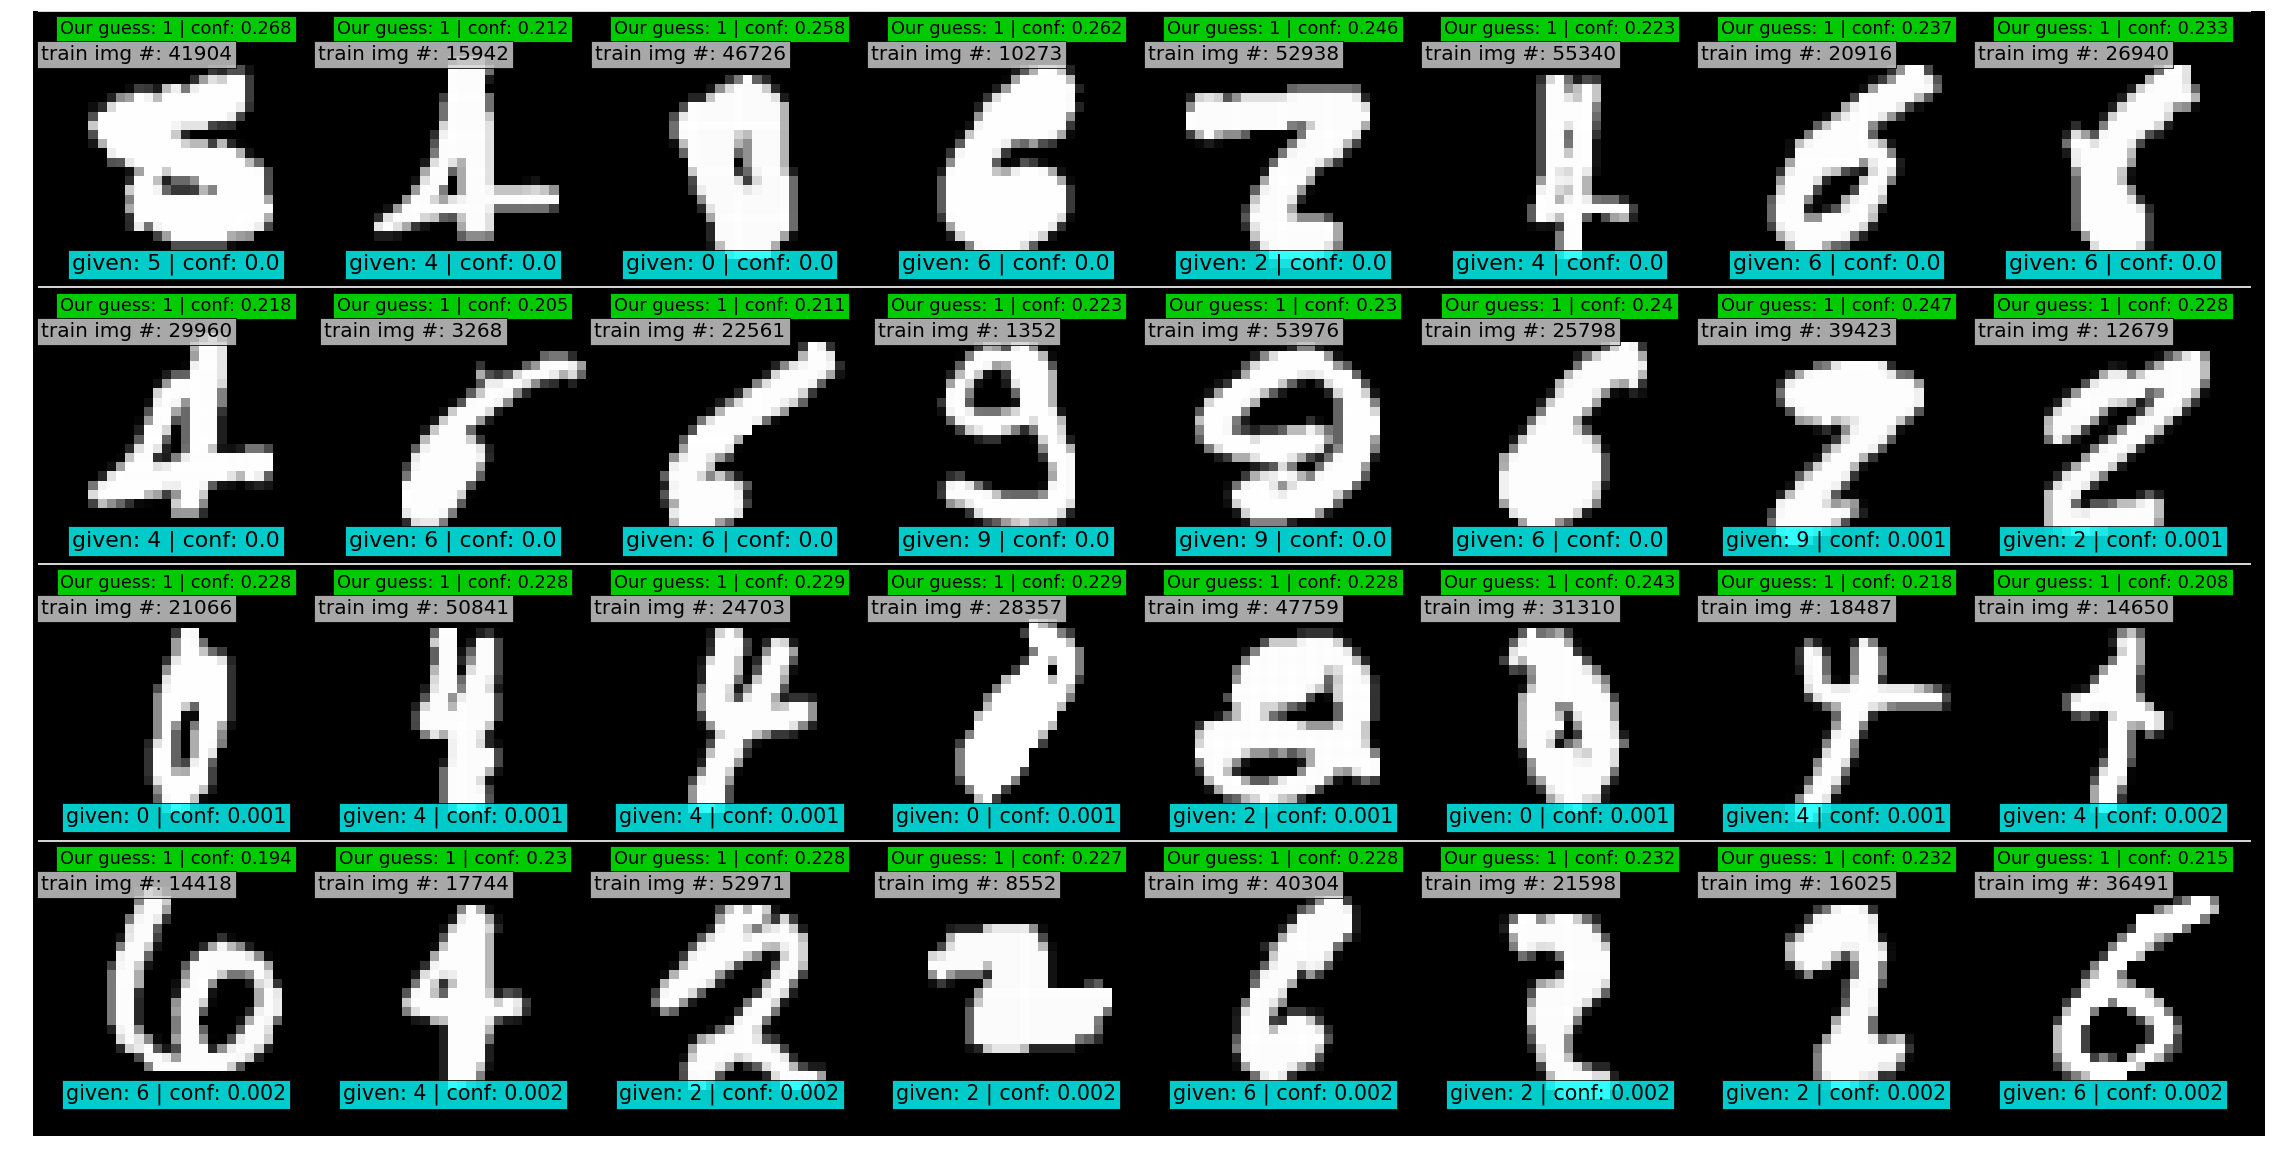

TOLERANCE 5 METHOD: prune_by_class


/Users/cgn/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:382: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


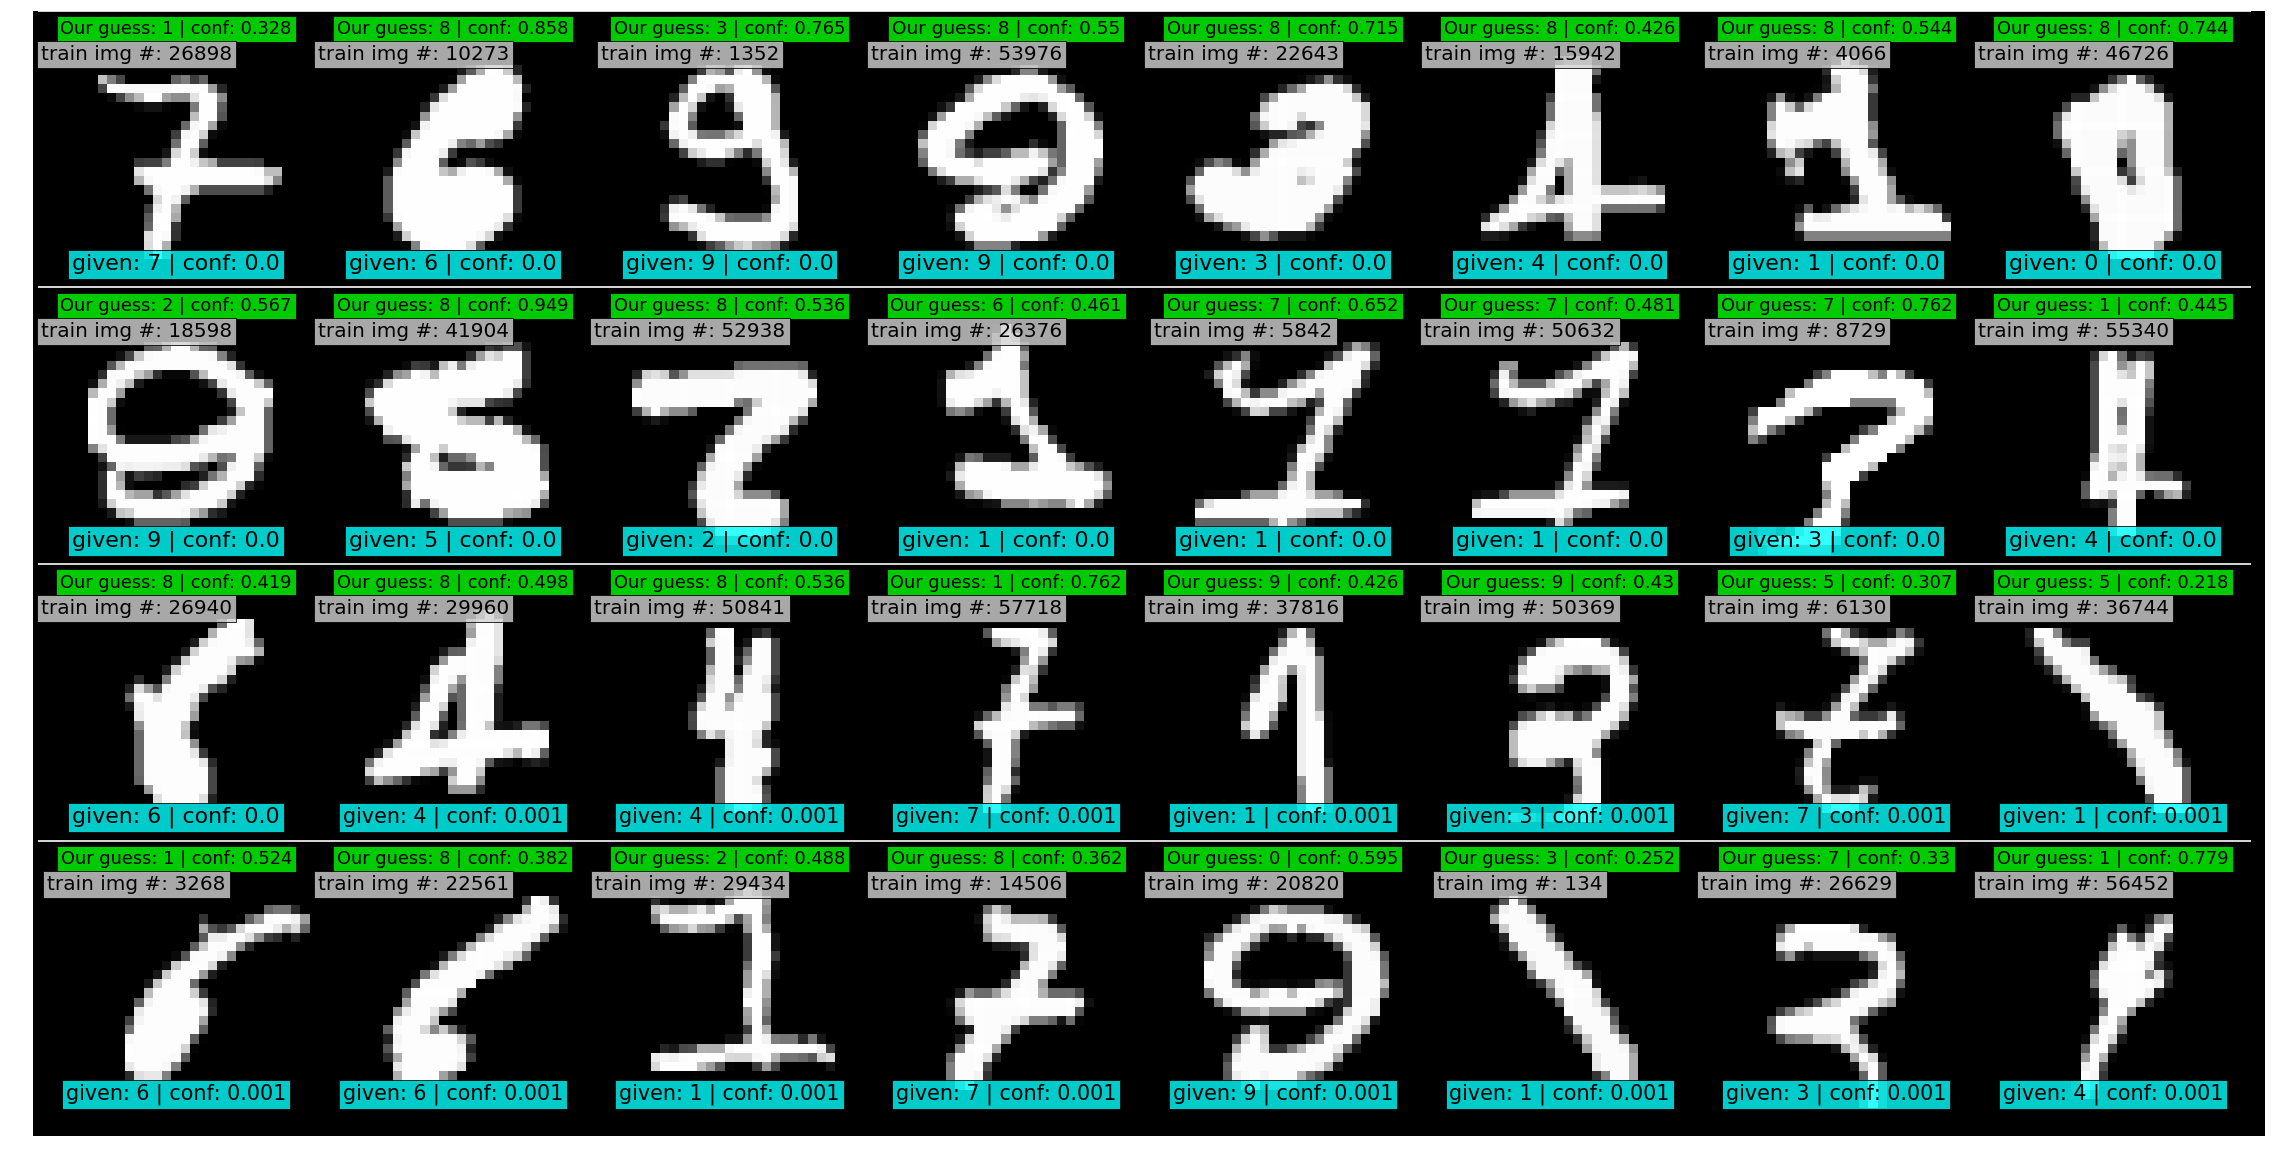

TOLERANCE 5 METHOD: prune_by_noise_rate


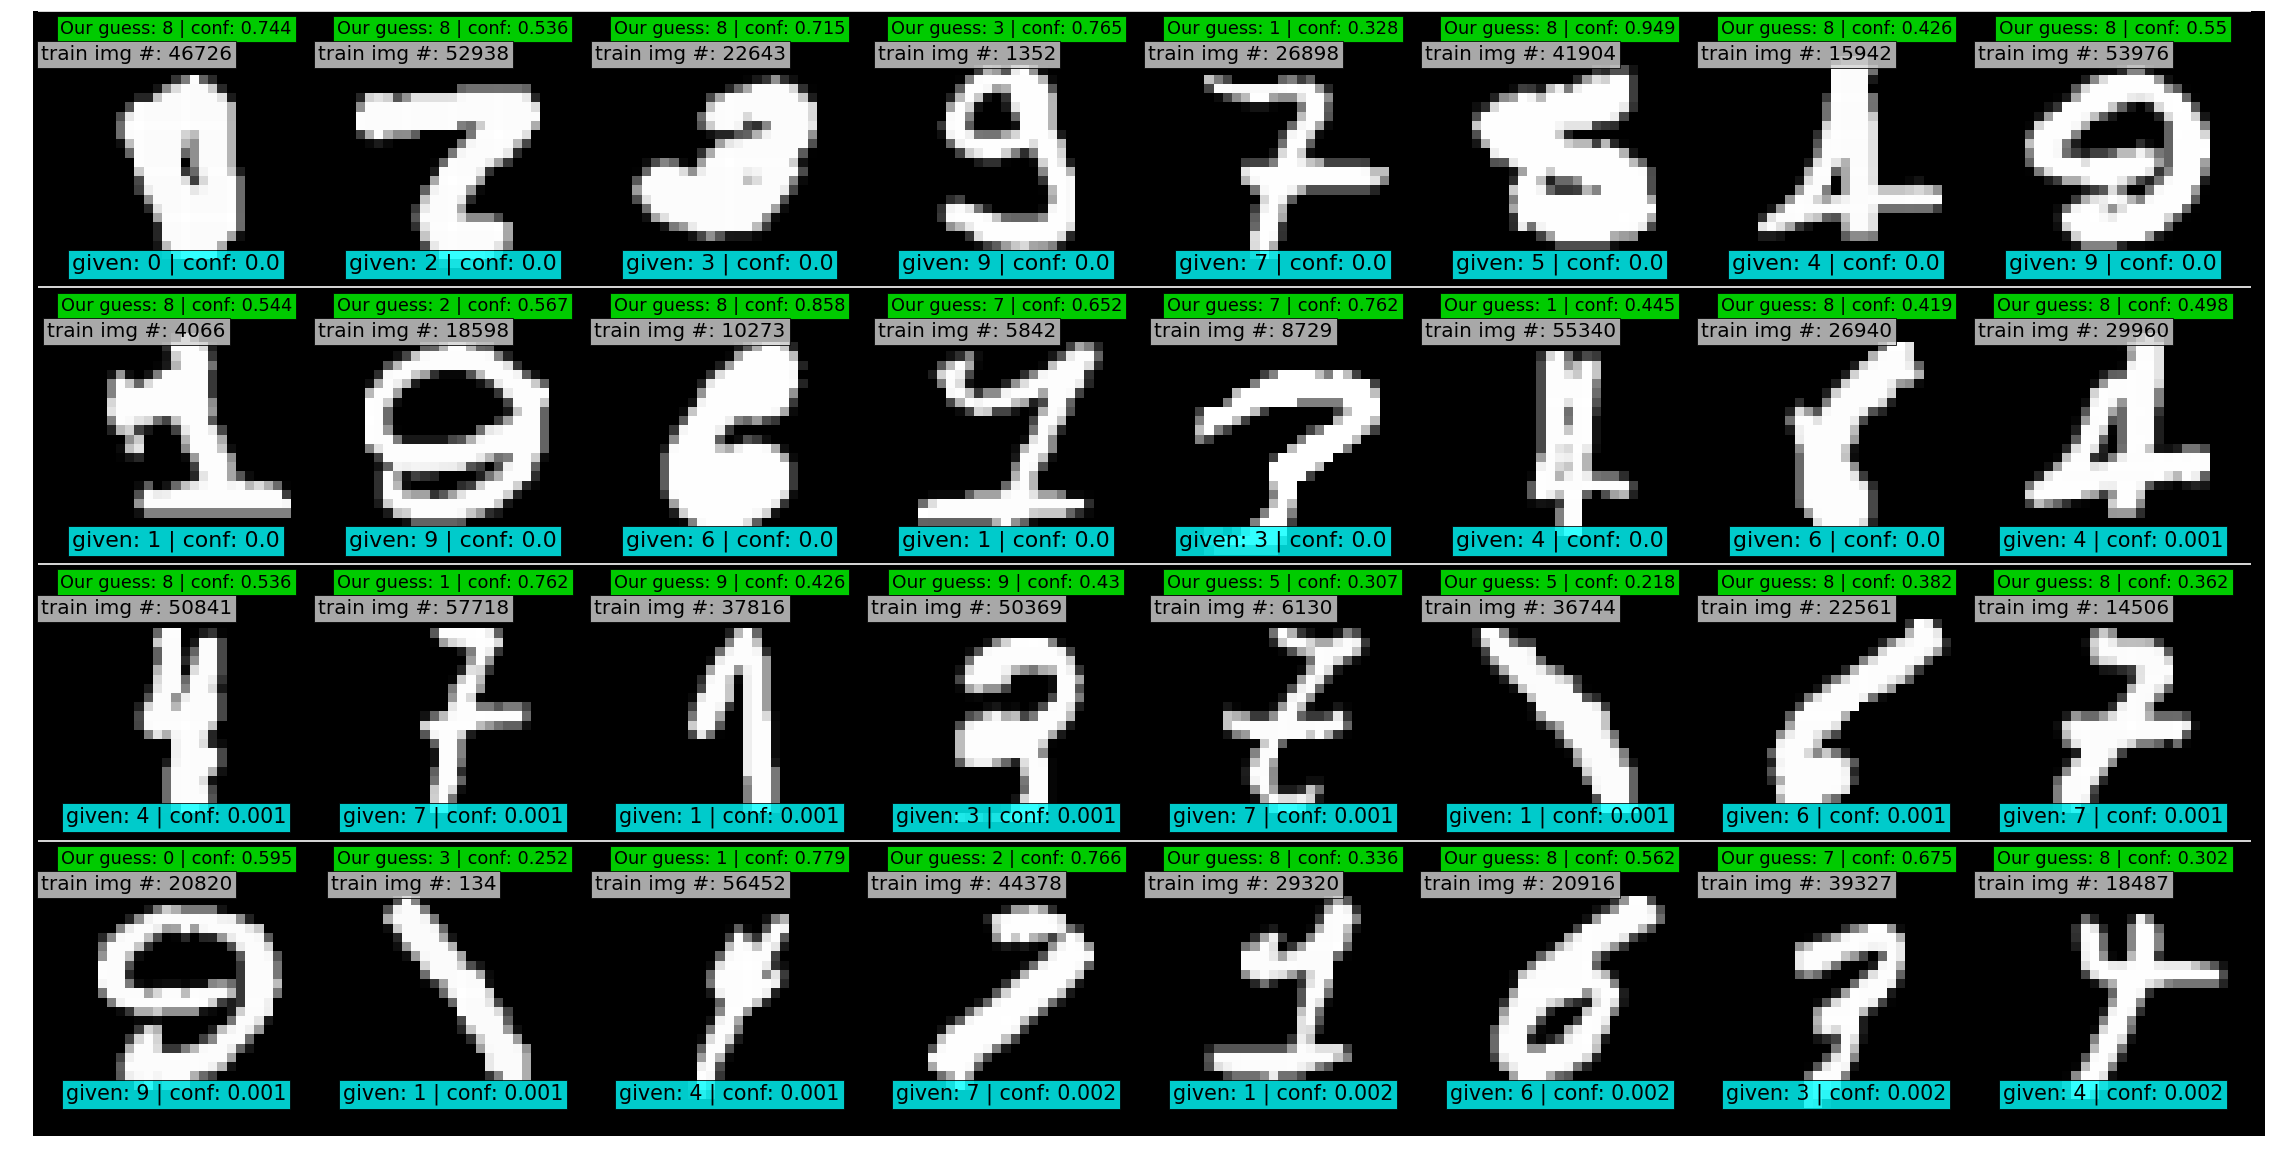

TOLERANCE 5 METHOD: both


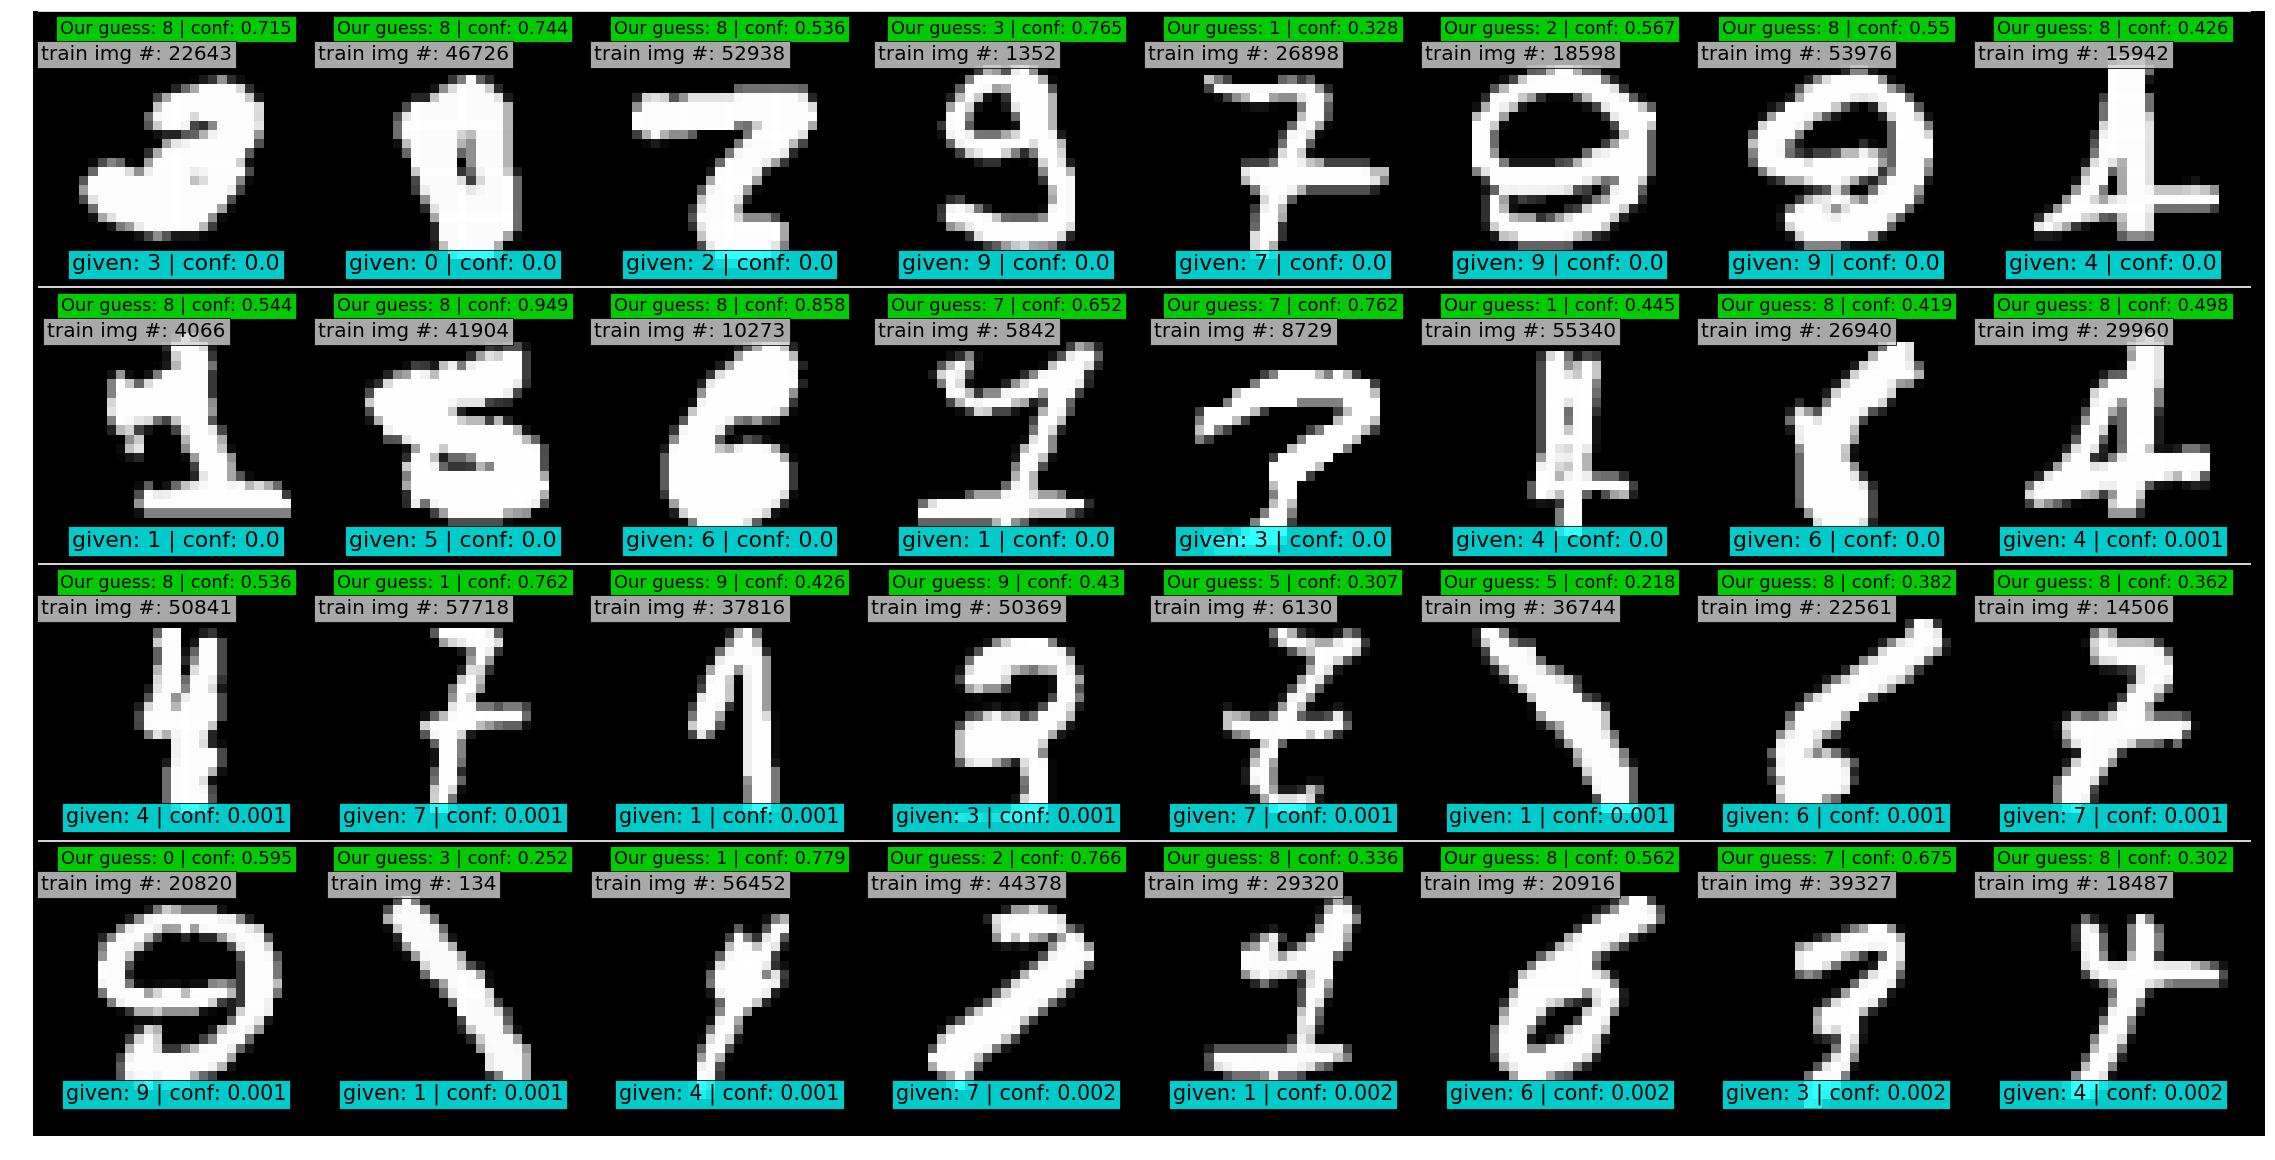

TOLERANCE 1 METHOD: prune_by_class


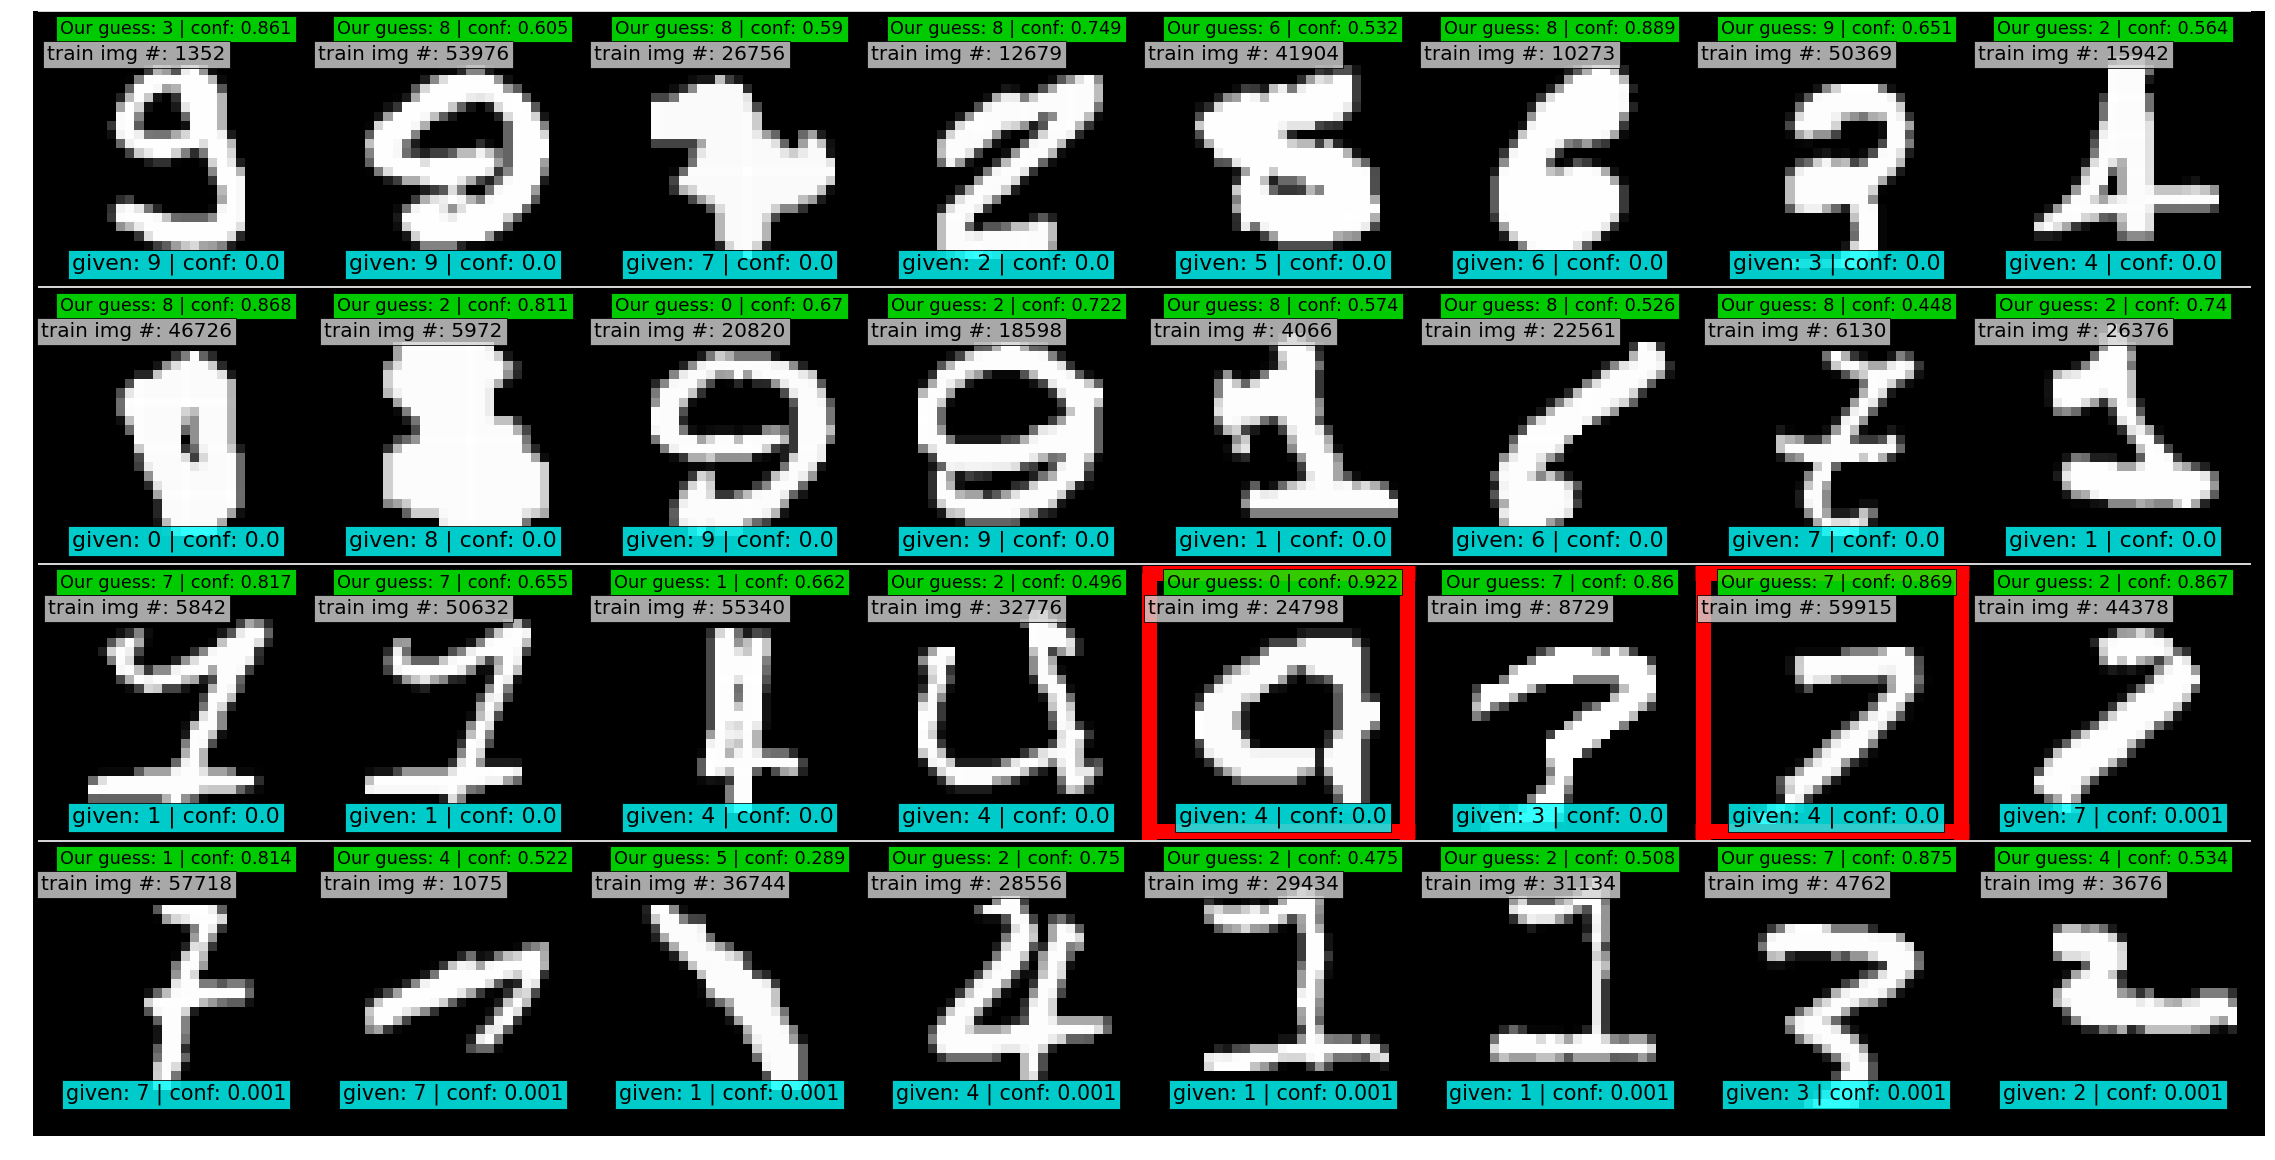

TOLERANCE 1 METHOD: prune_by_noise_rate


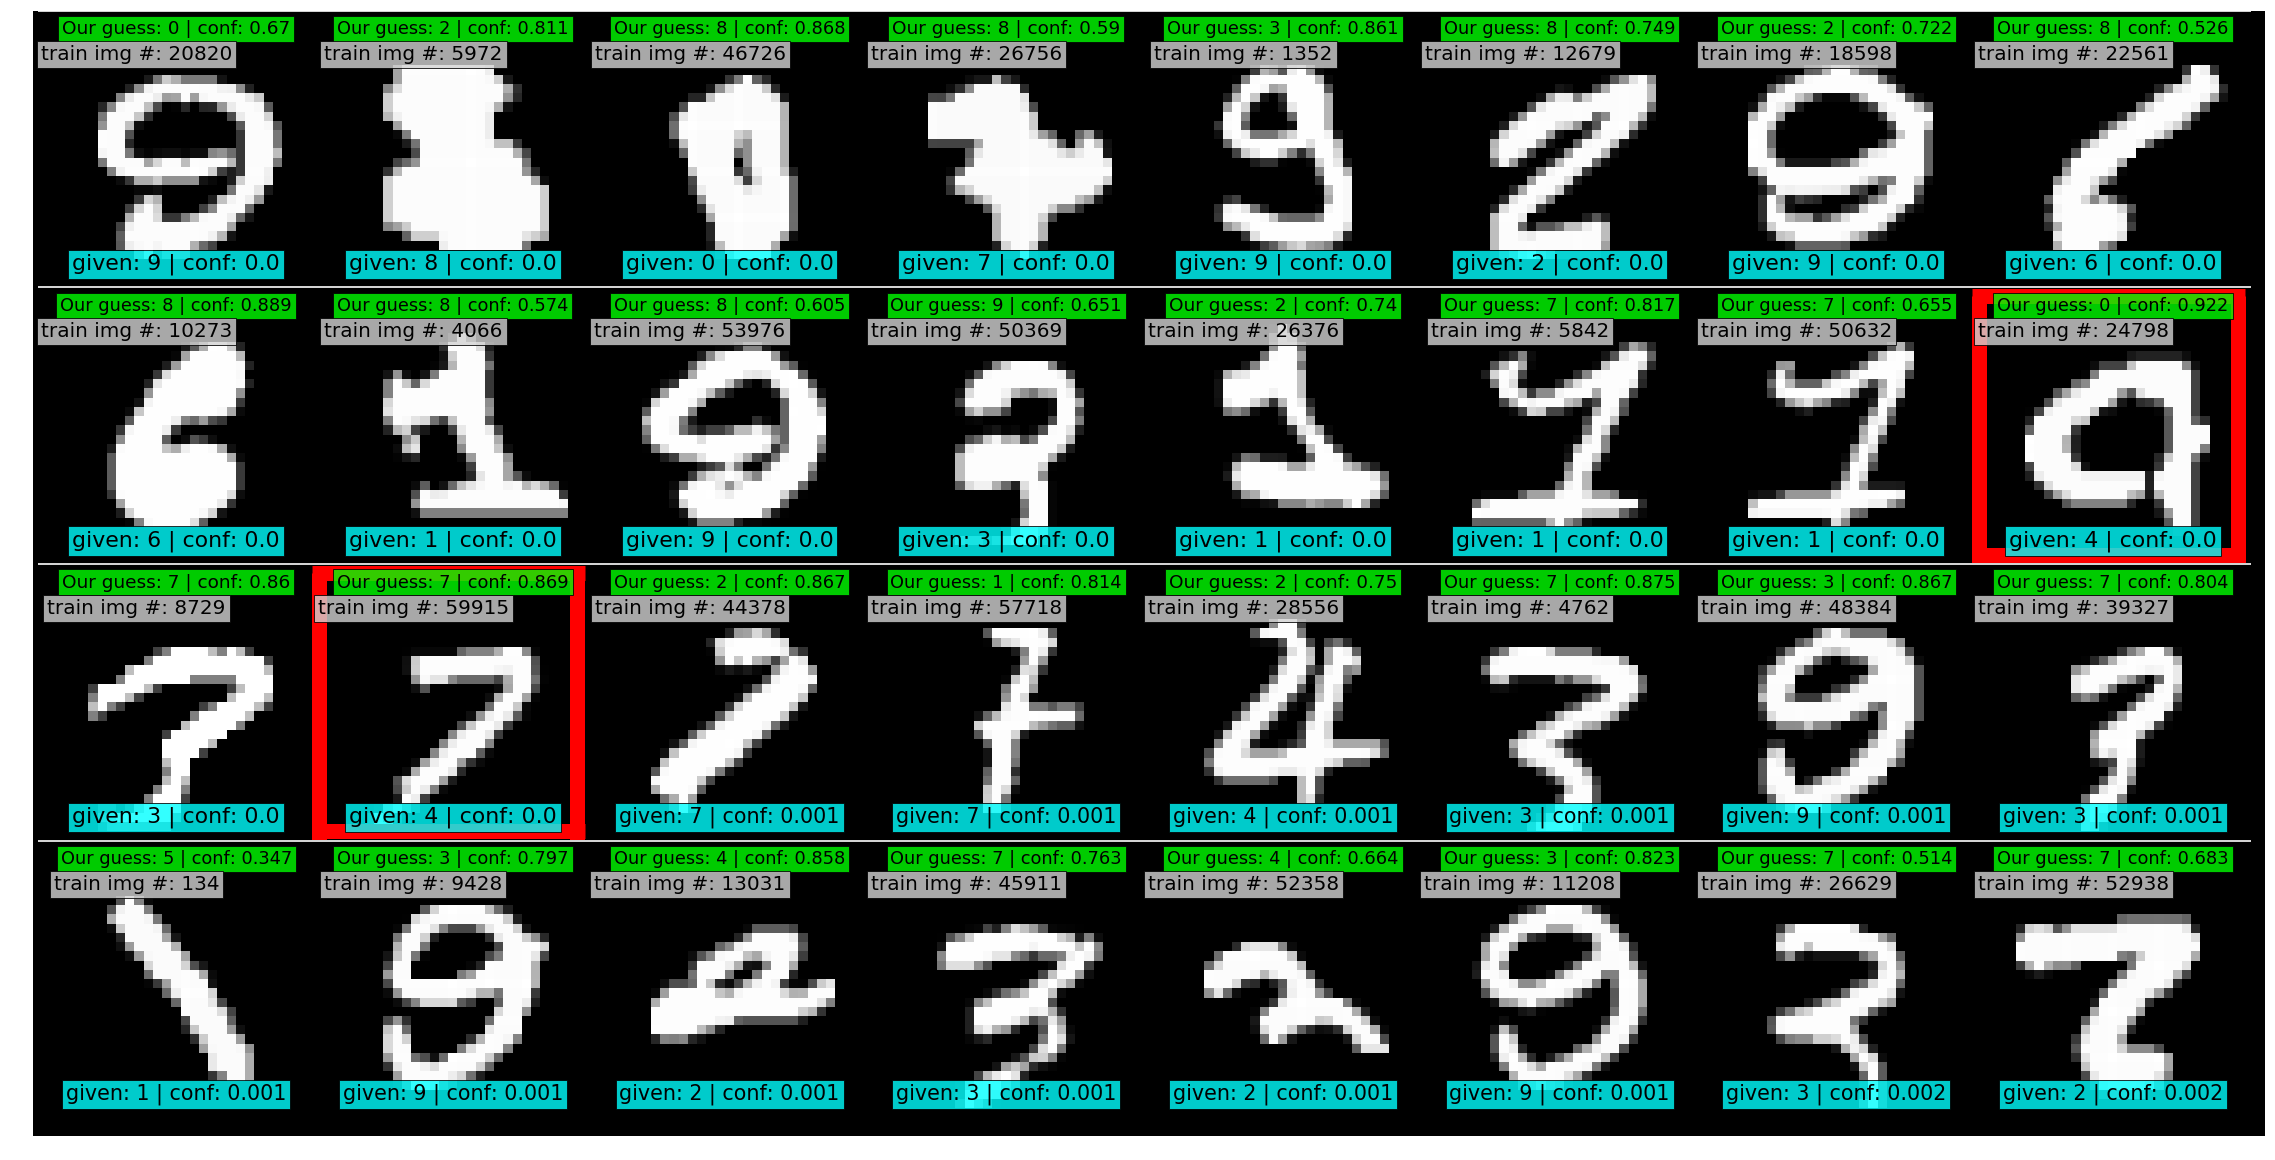

TOLERANCE 1 METHOD: both


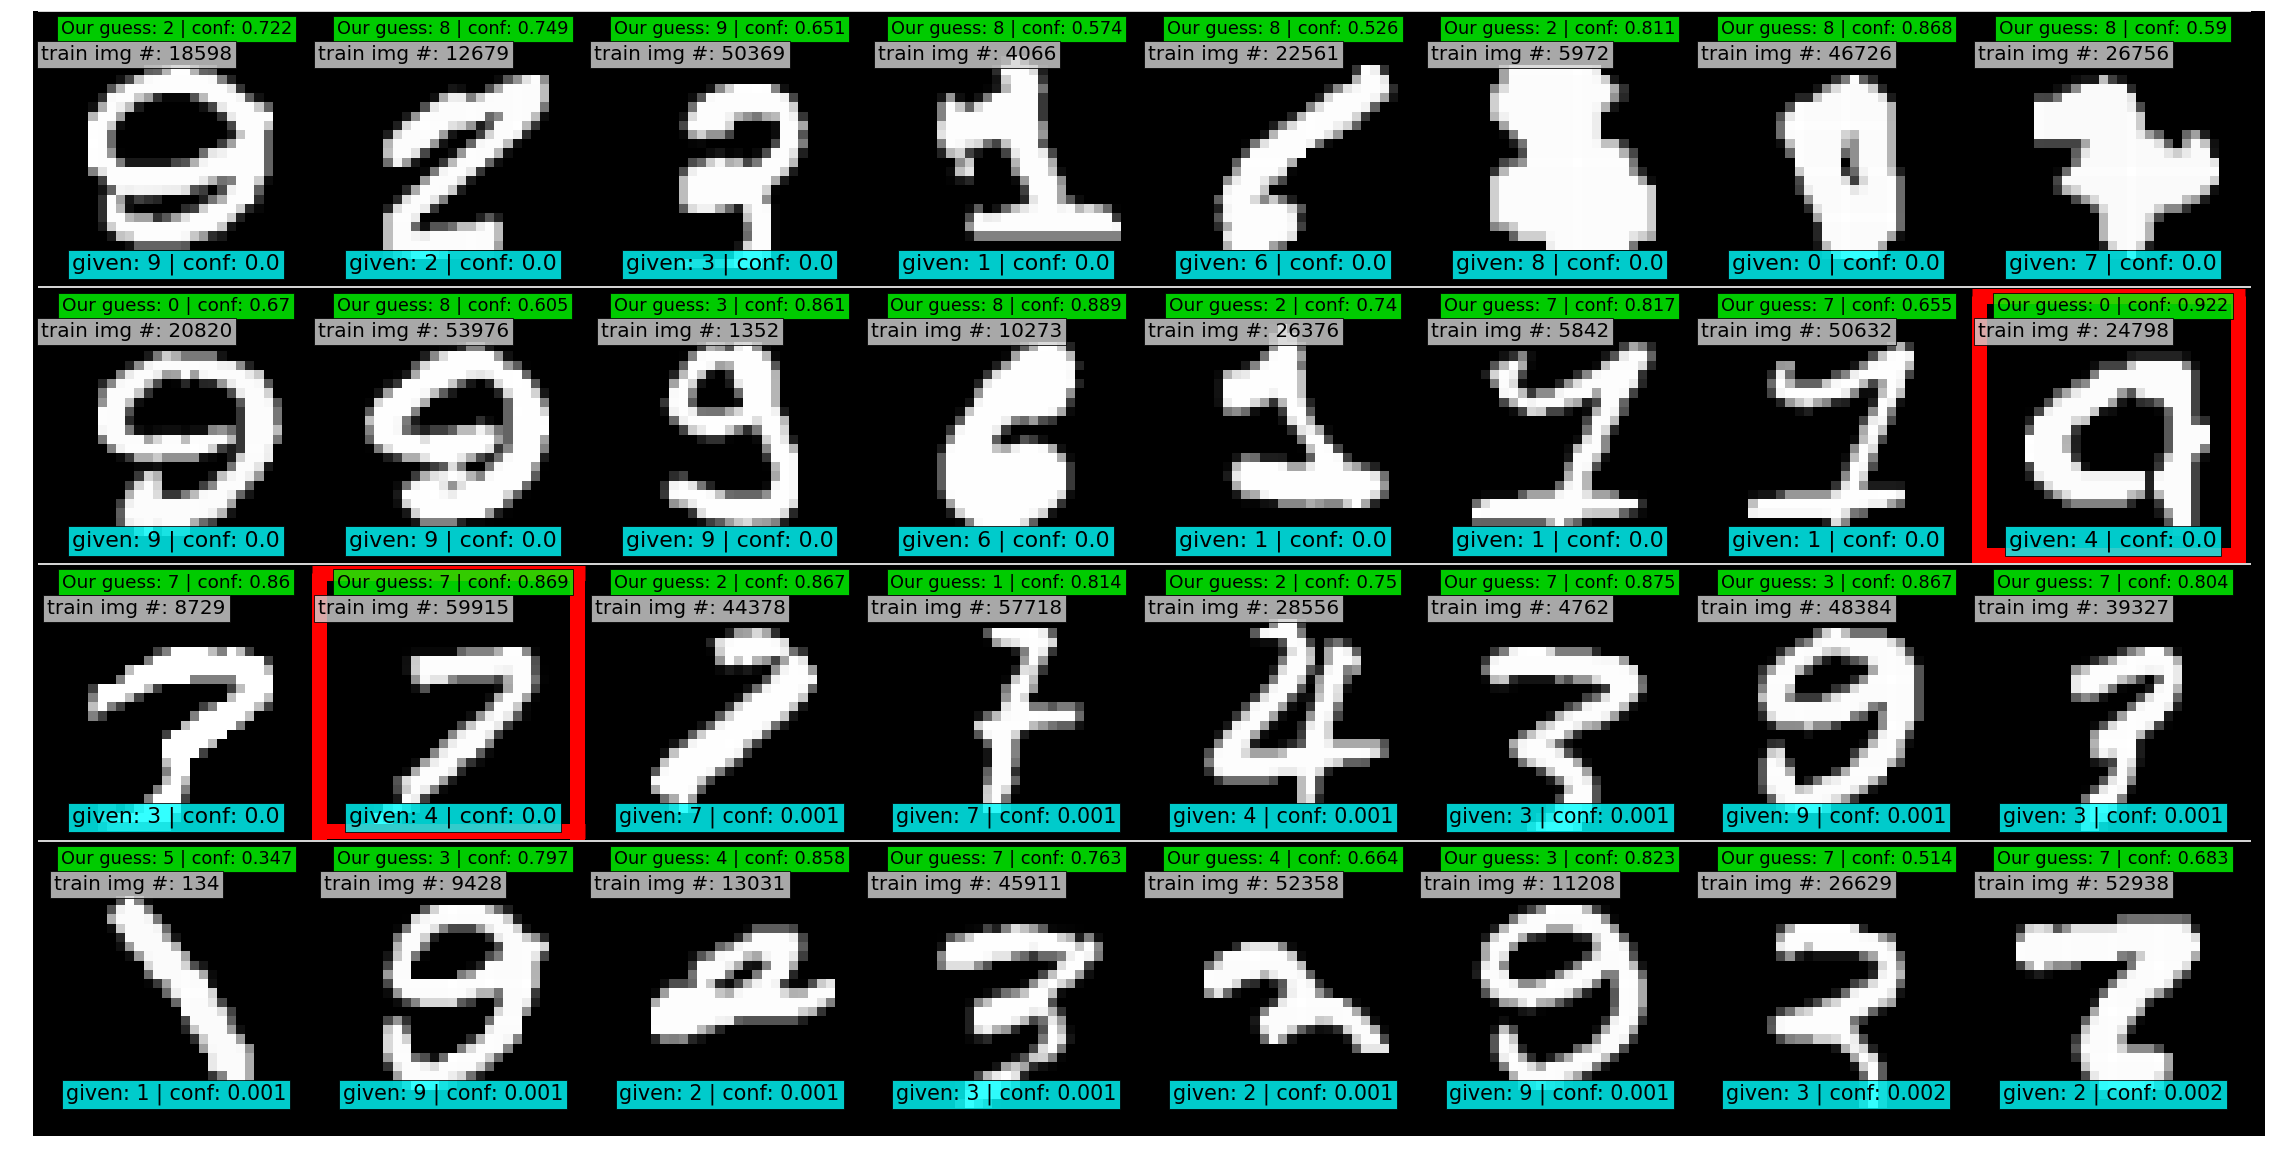

TOLERANCE 0.5 METHOD: prune_by_class


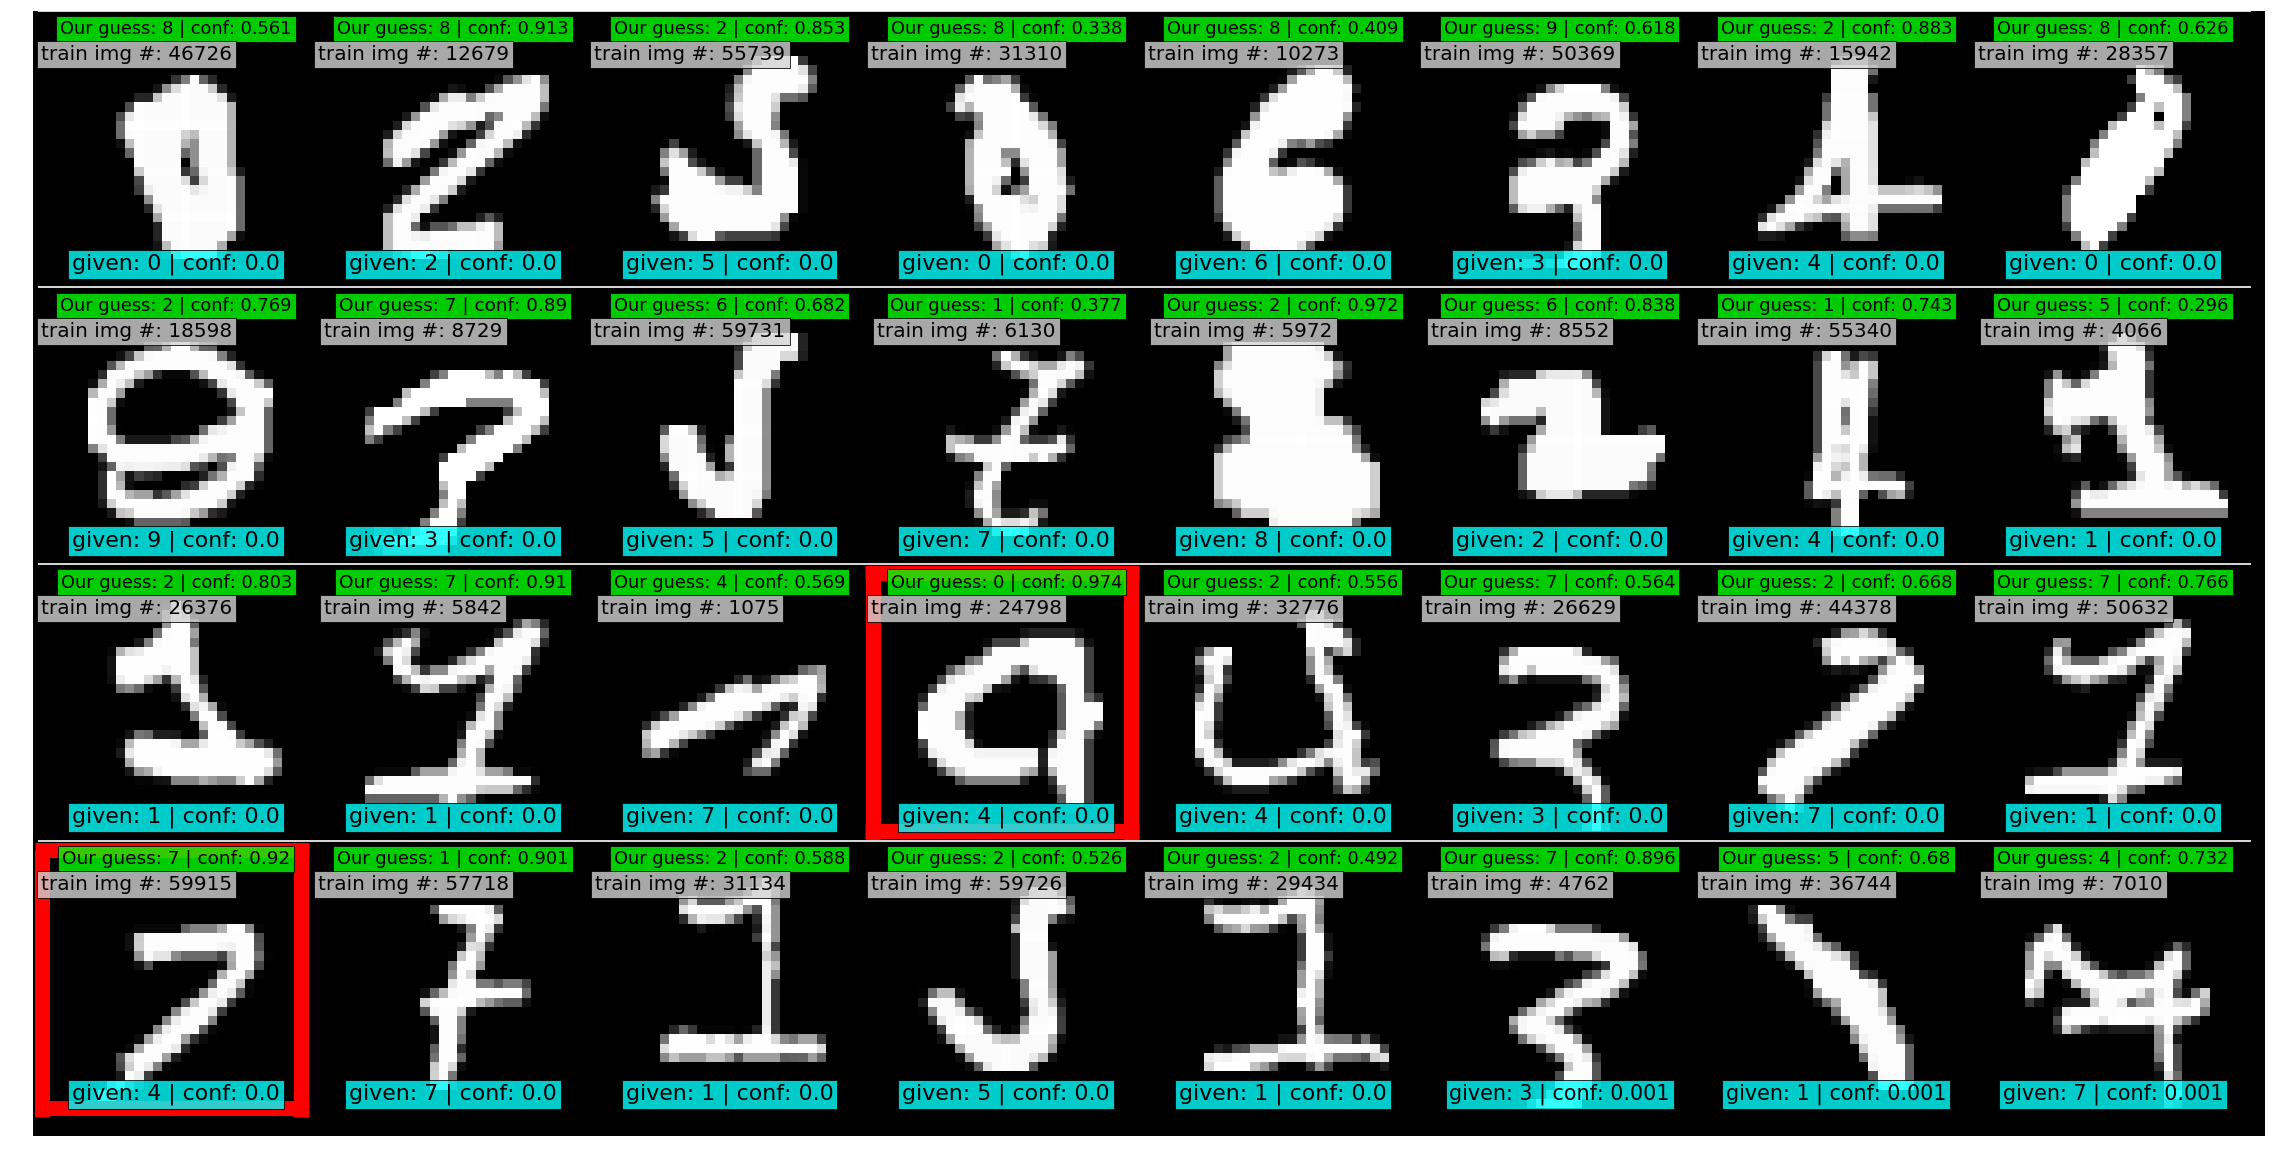

TOLERANCE 0.5 METHOD: prune_by_noise_rate


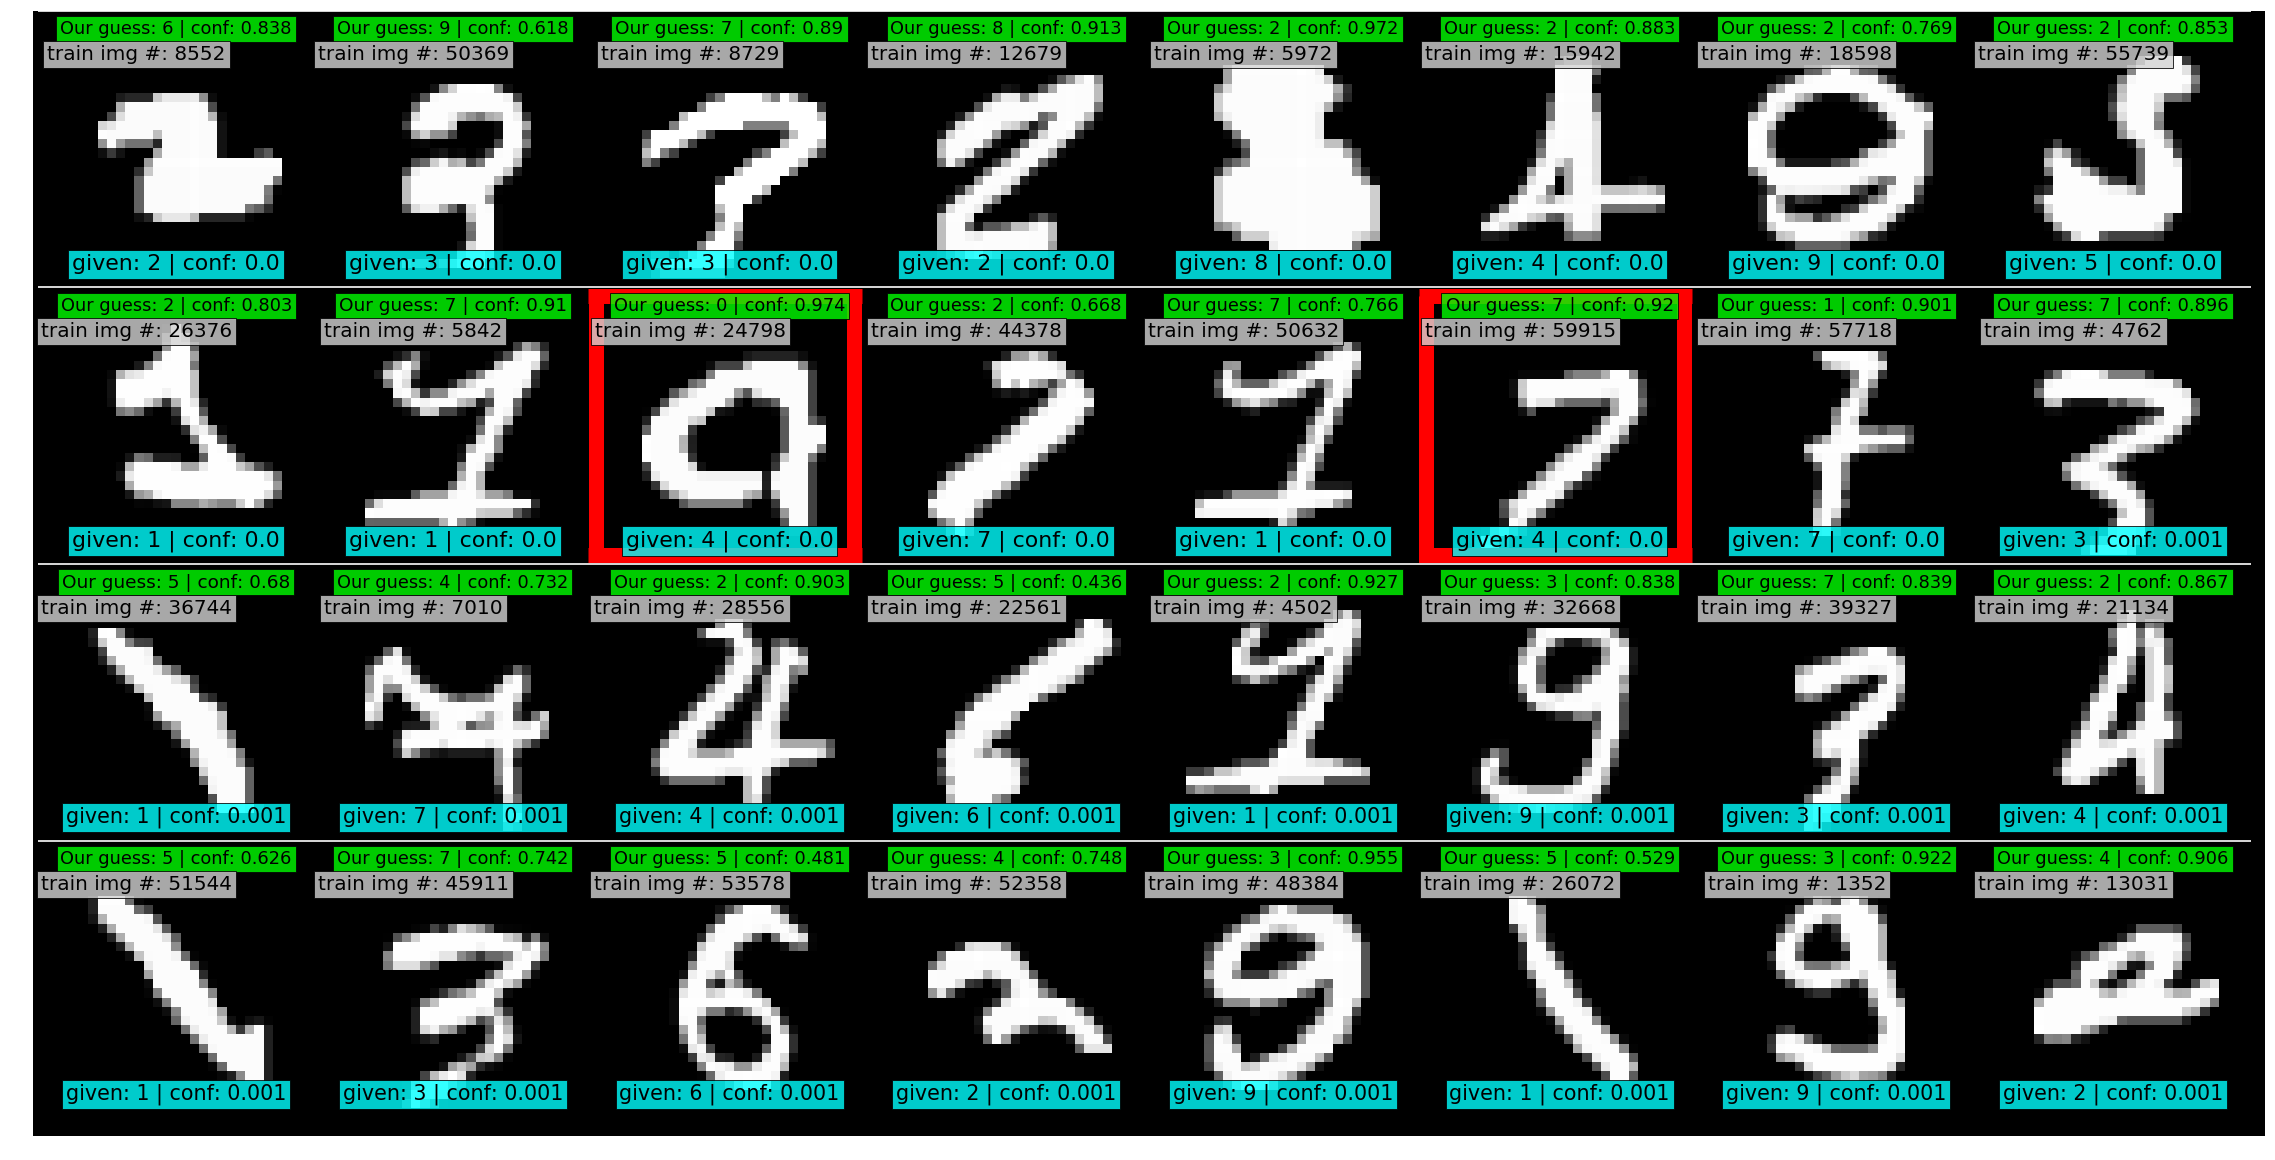

TOLERANCE 0.5 METHOD: both


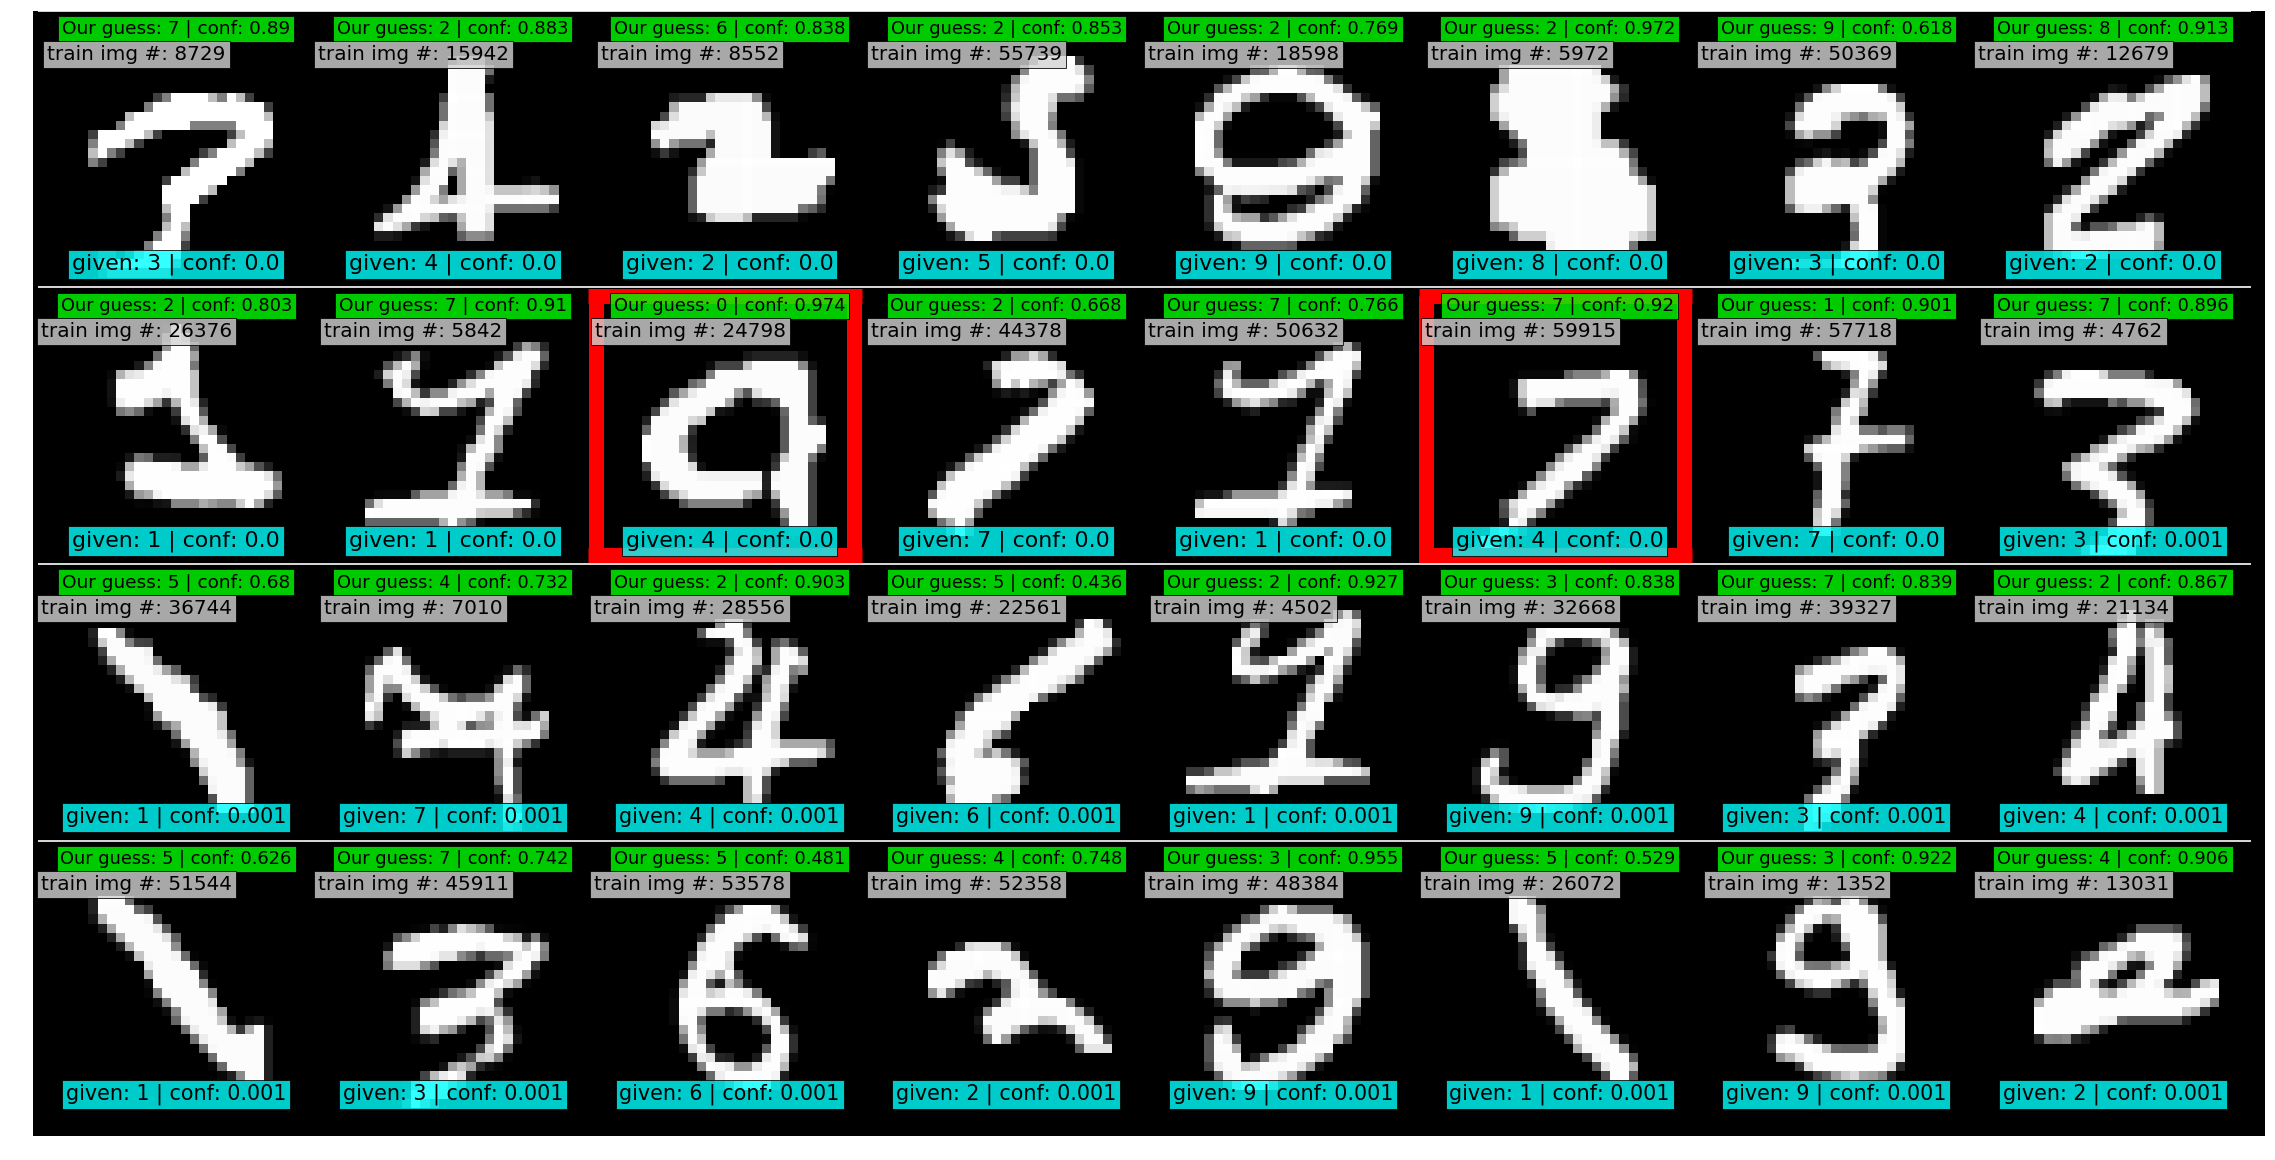

TOLERANCE 0.1 METHOD: prune_by_class


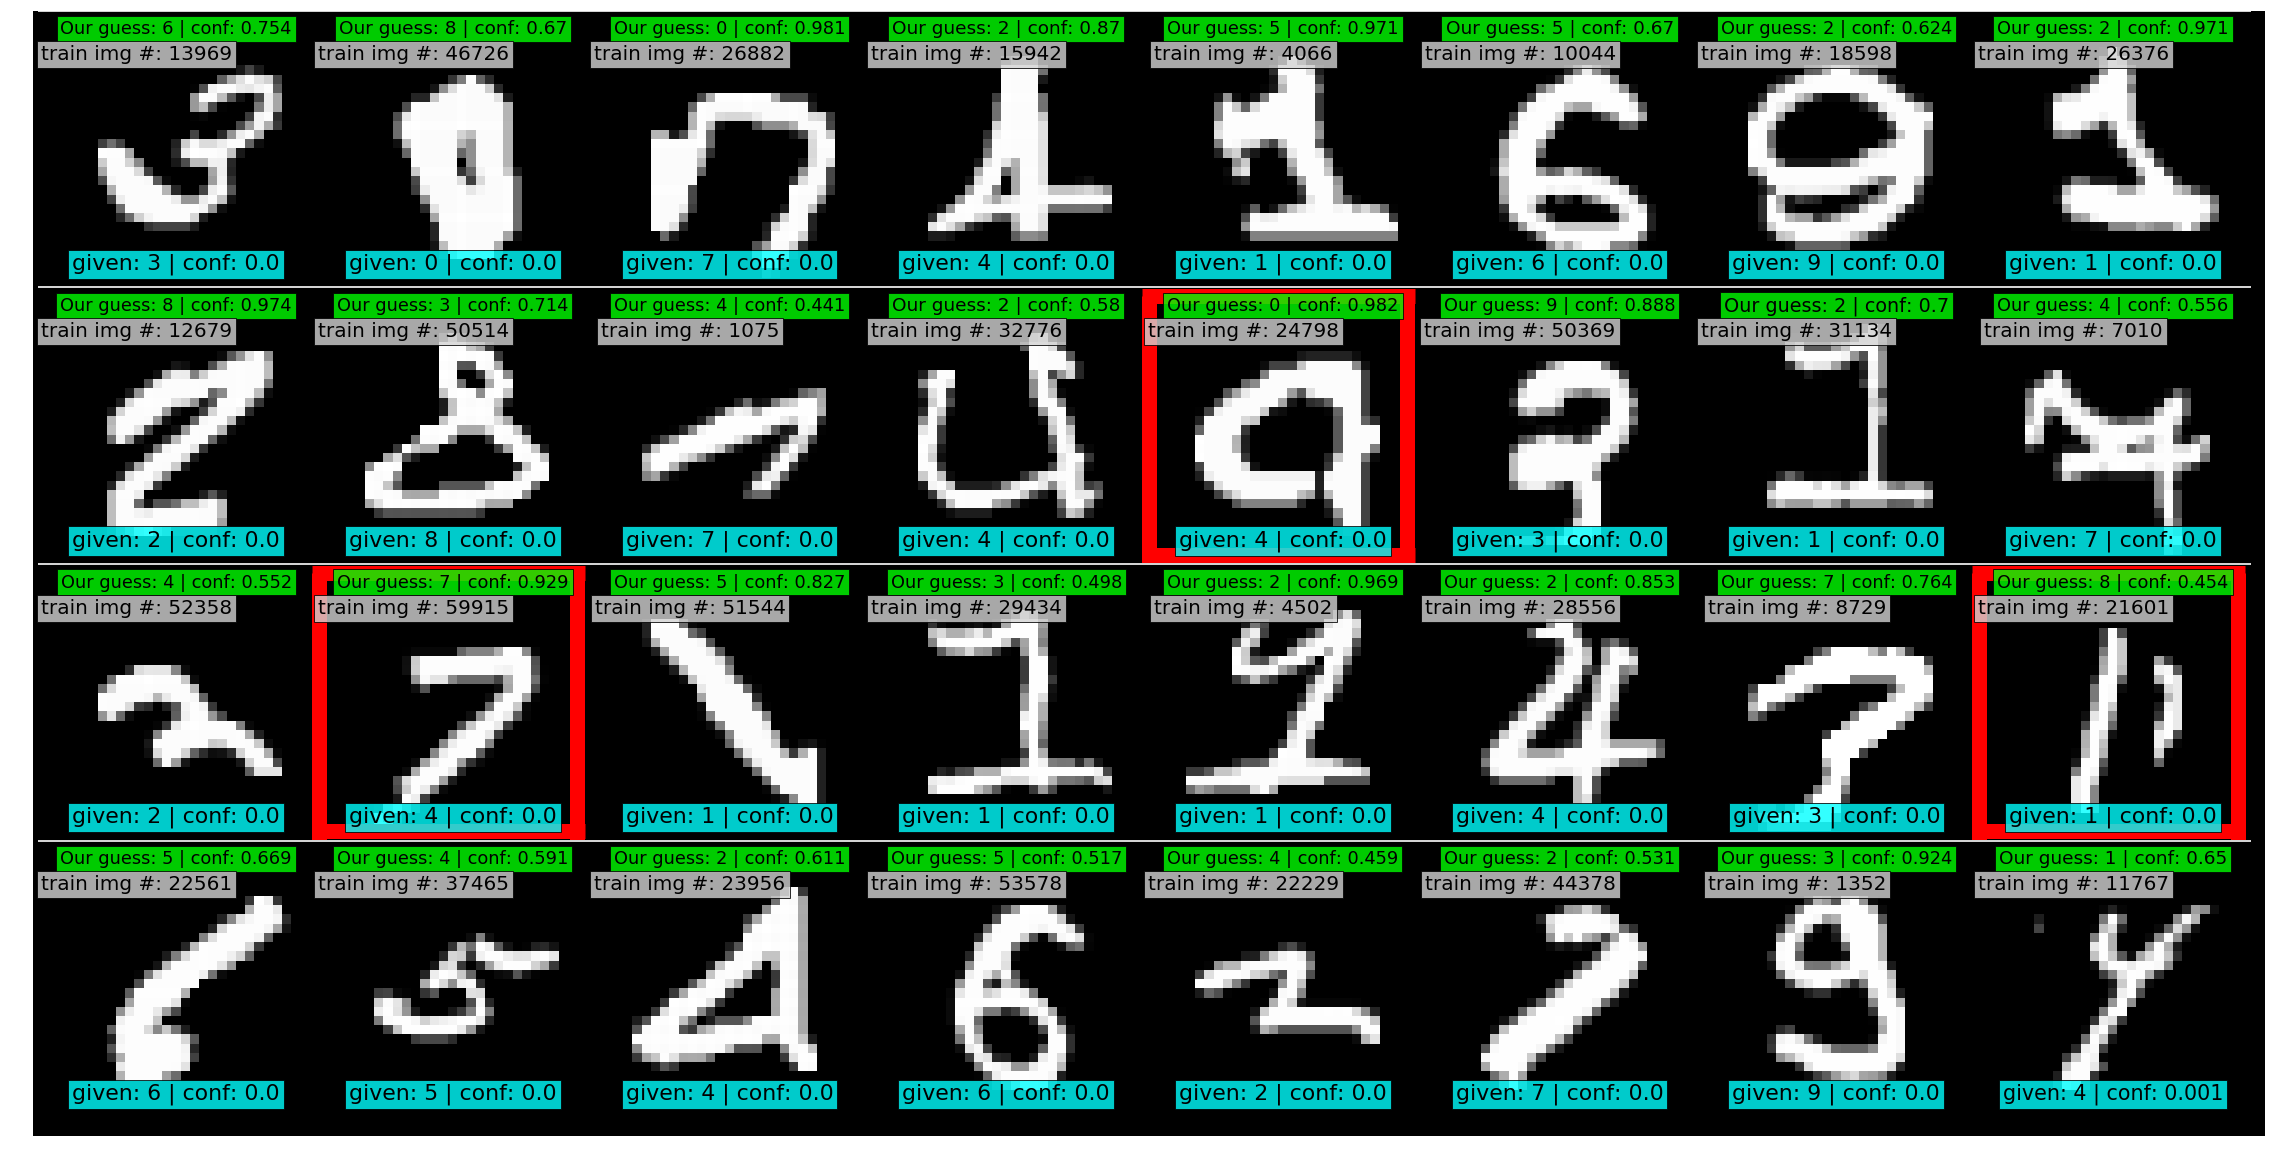

TOLERANCE 0.1 METHOD: prune_by_noise_rate


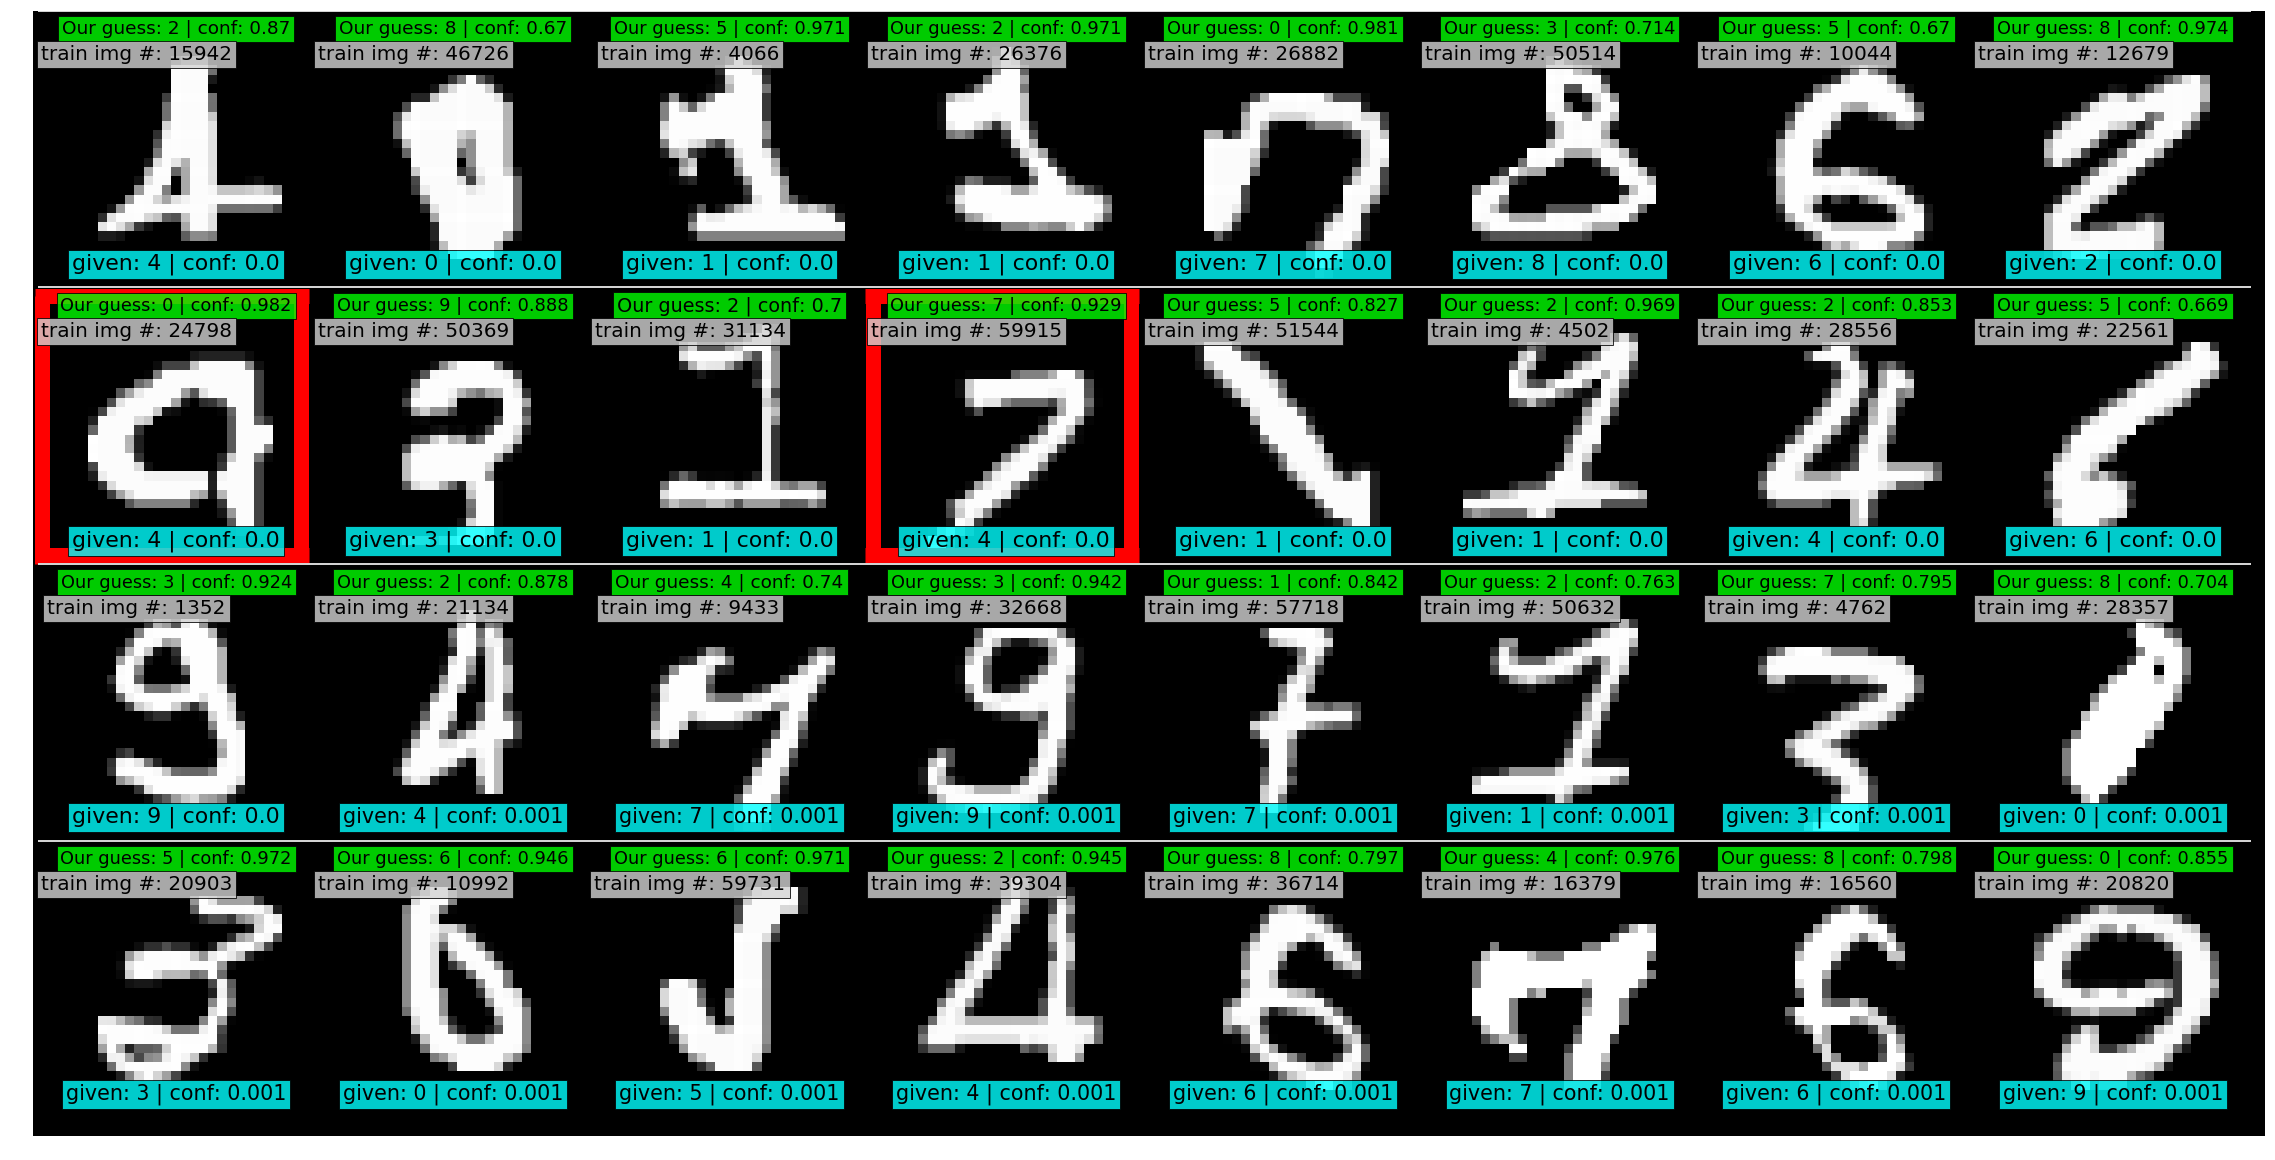

TOLERANCE 0.1 METHOD: both


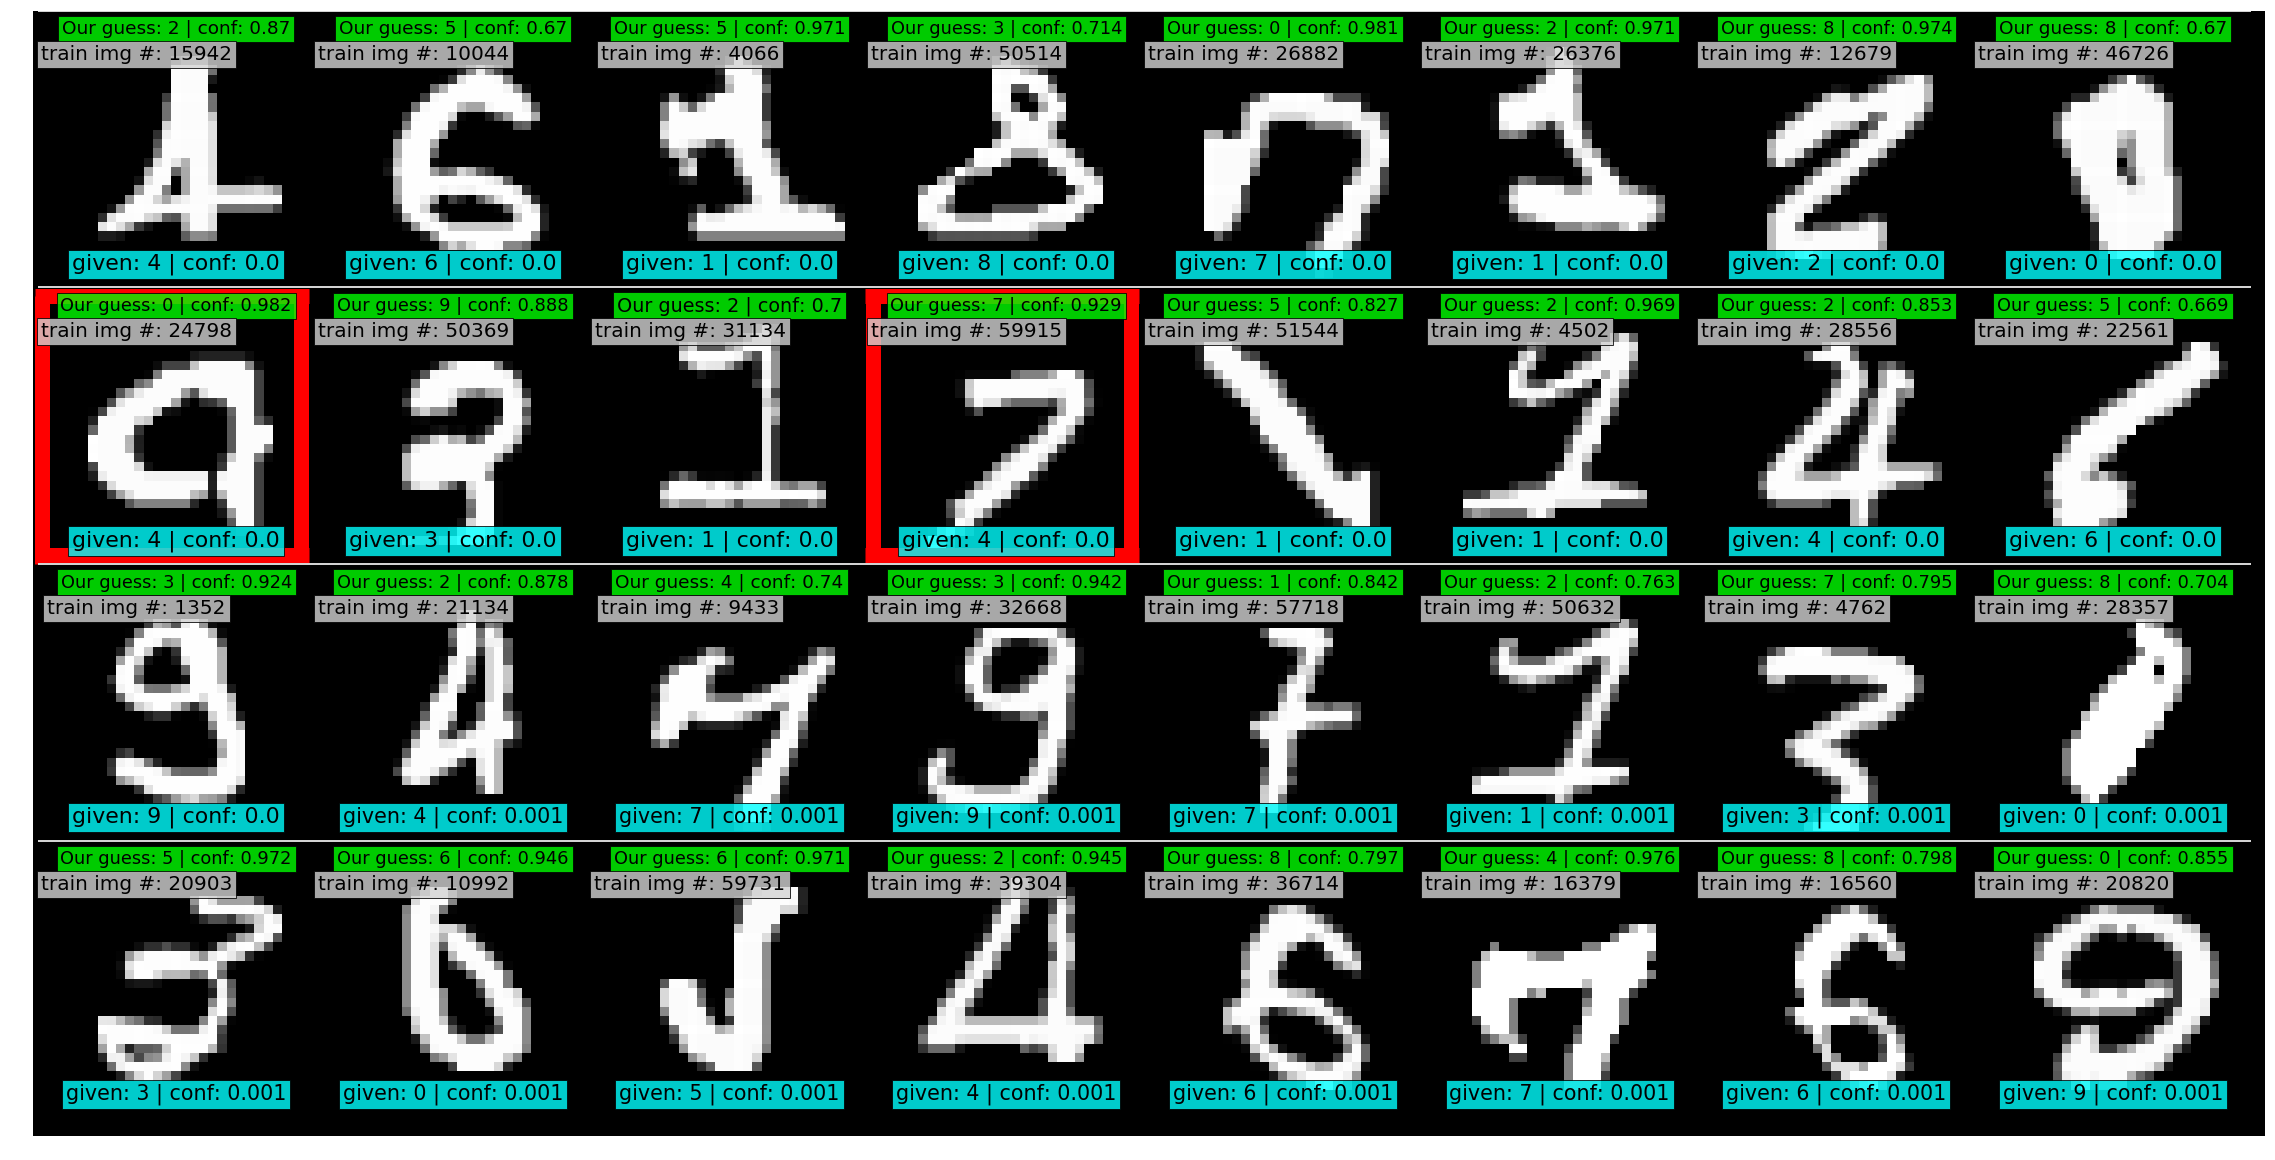

TOLERANCE 0.05 METHOD: prune_by_class


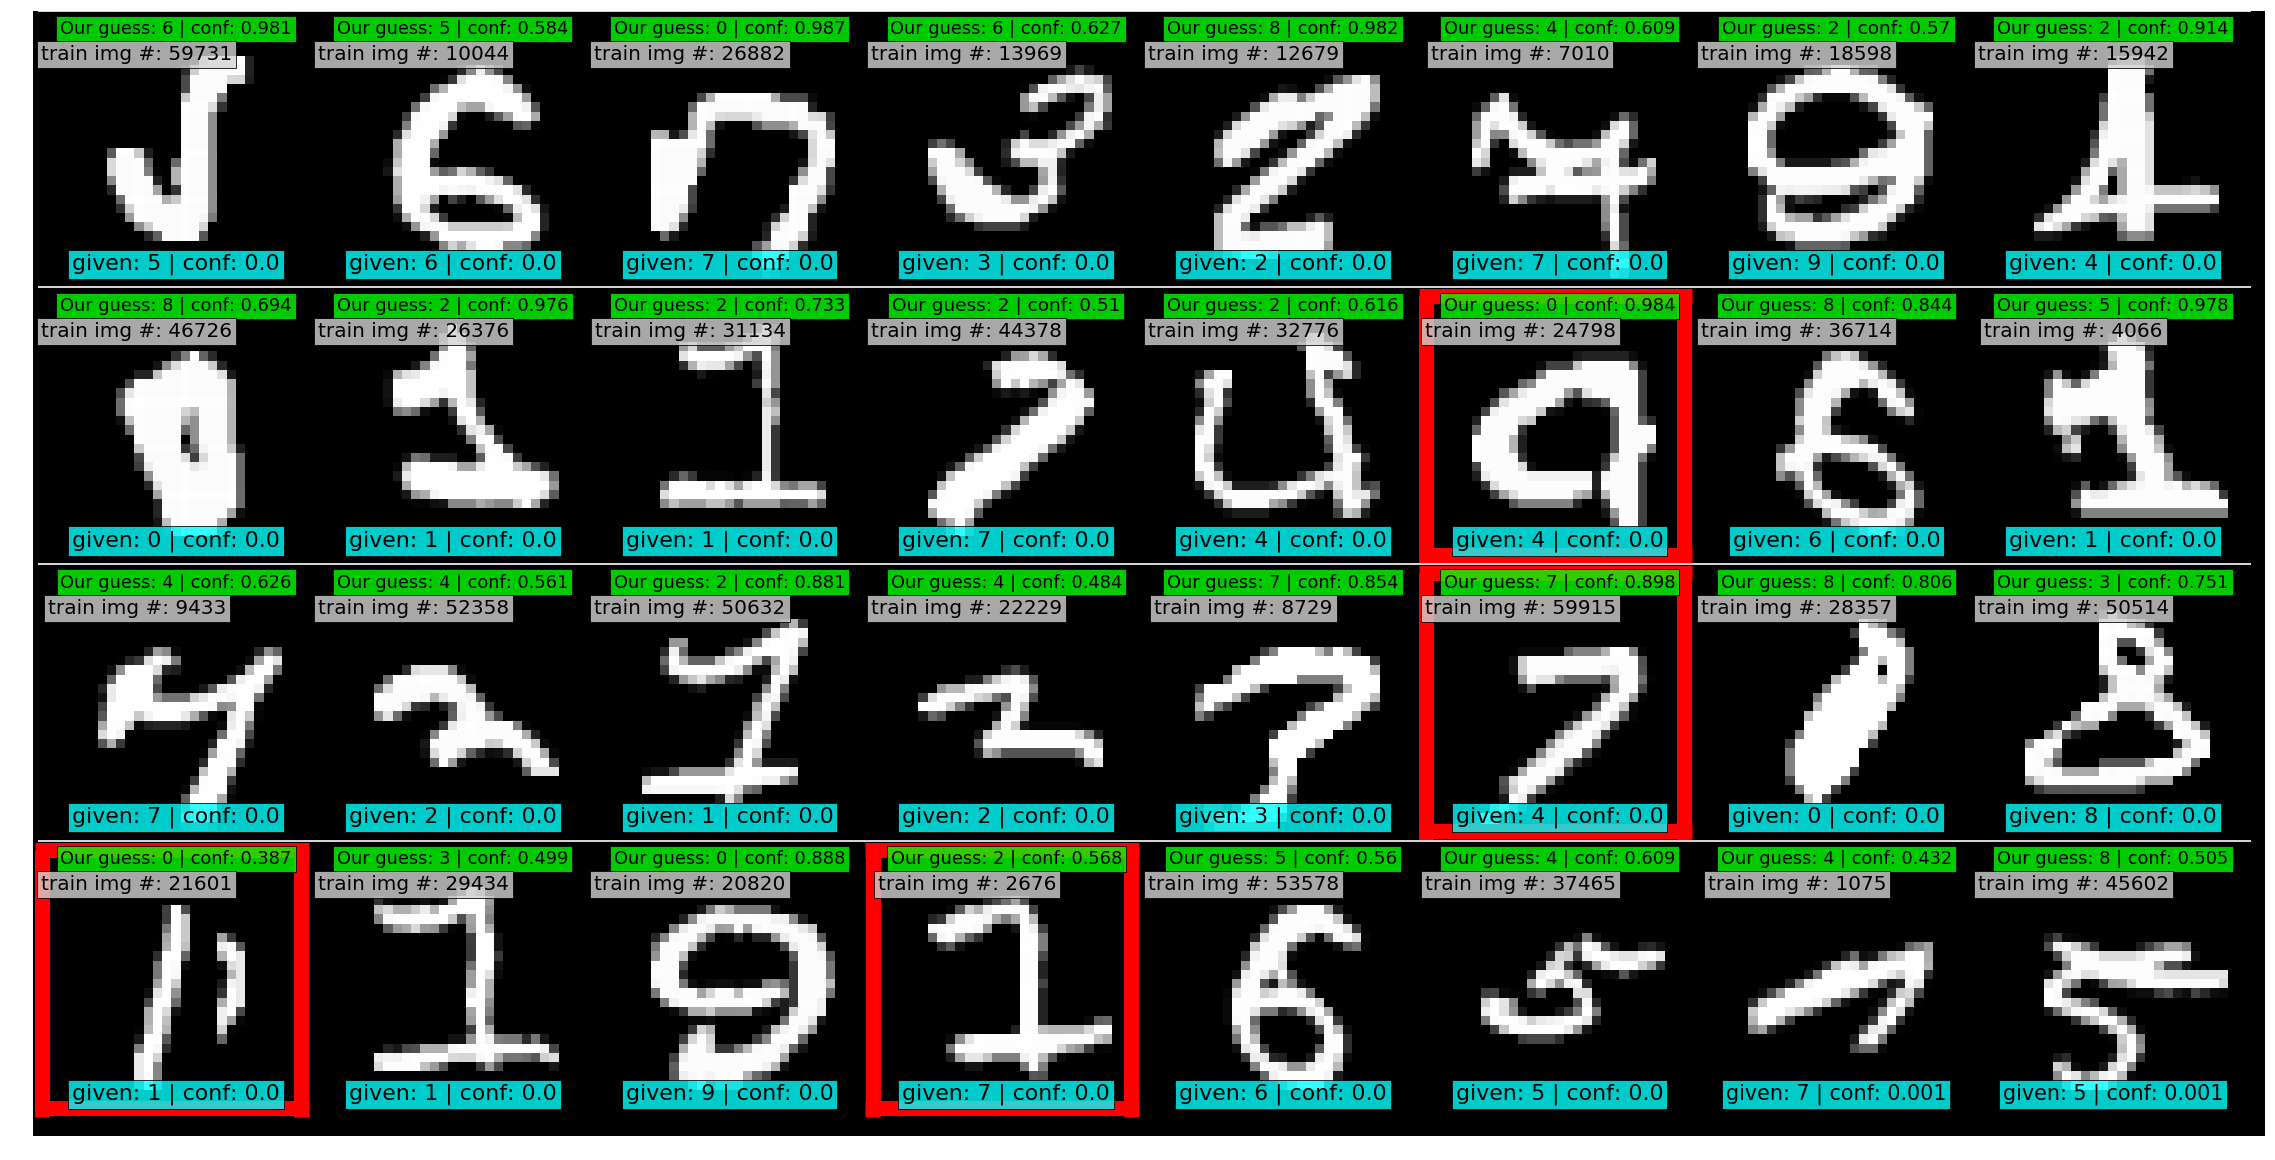

TOLERANCE 0.05 METHOD: prune_by_noise_rate


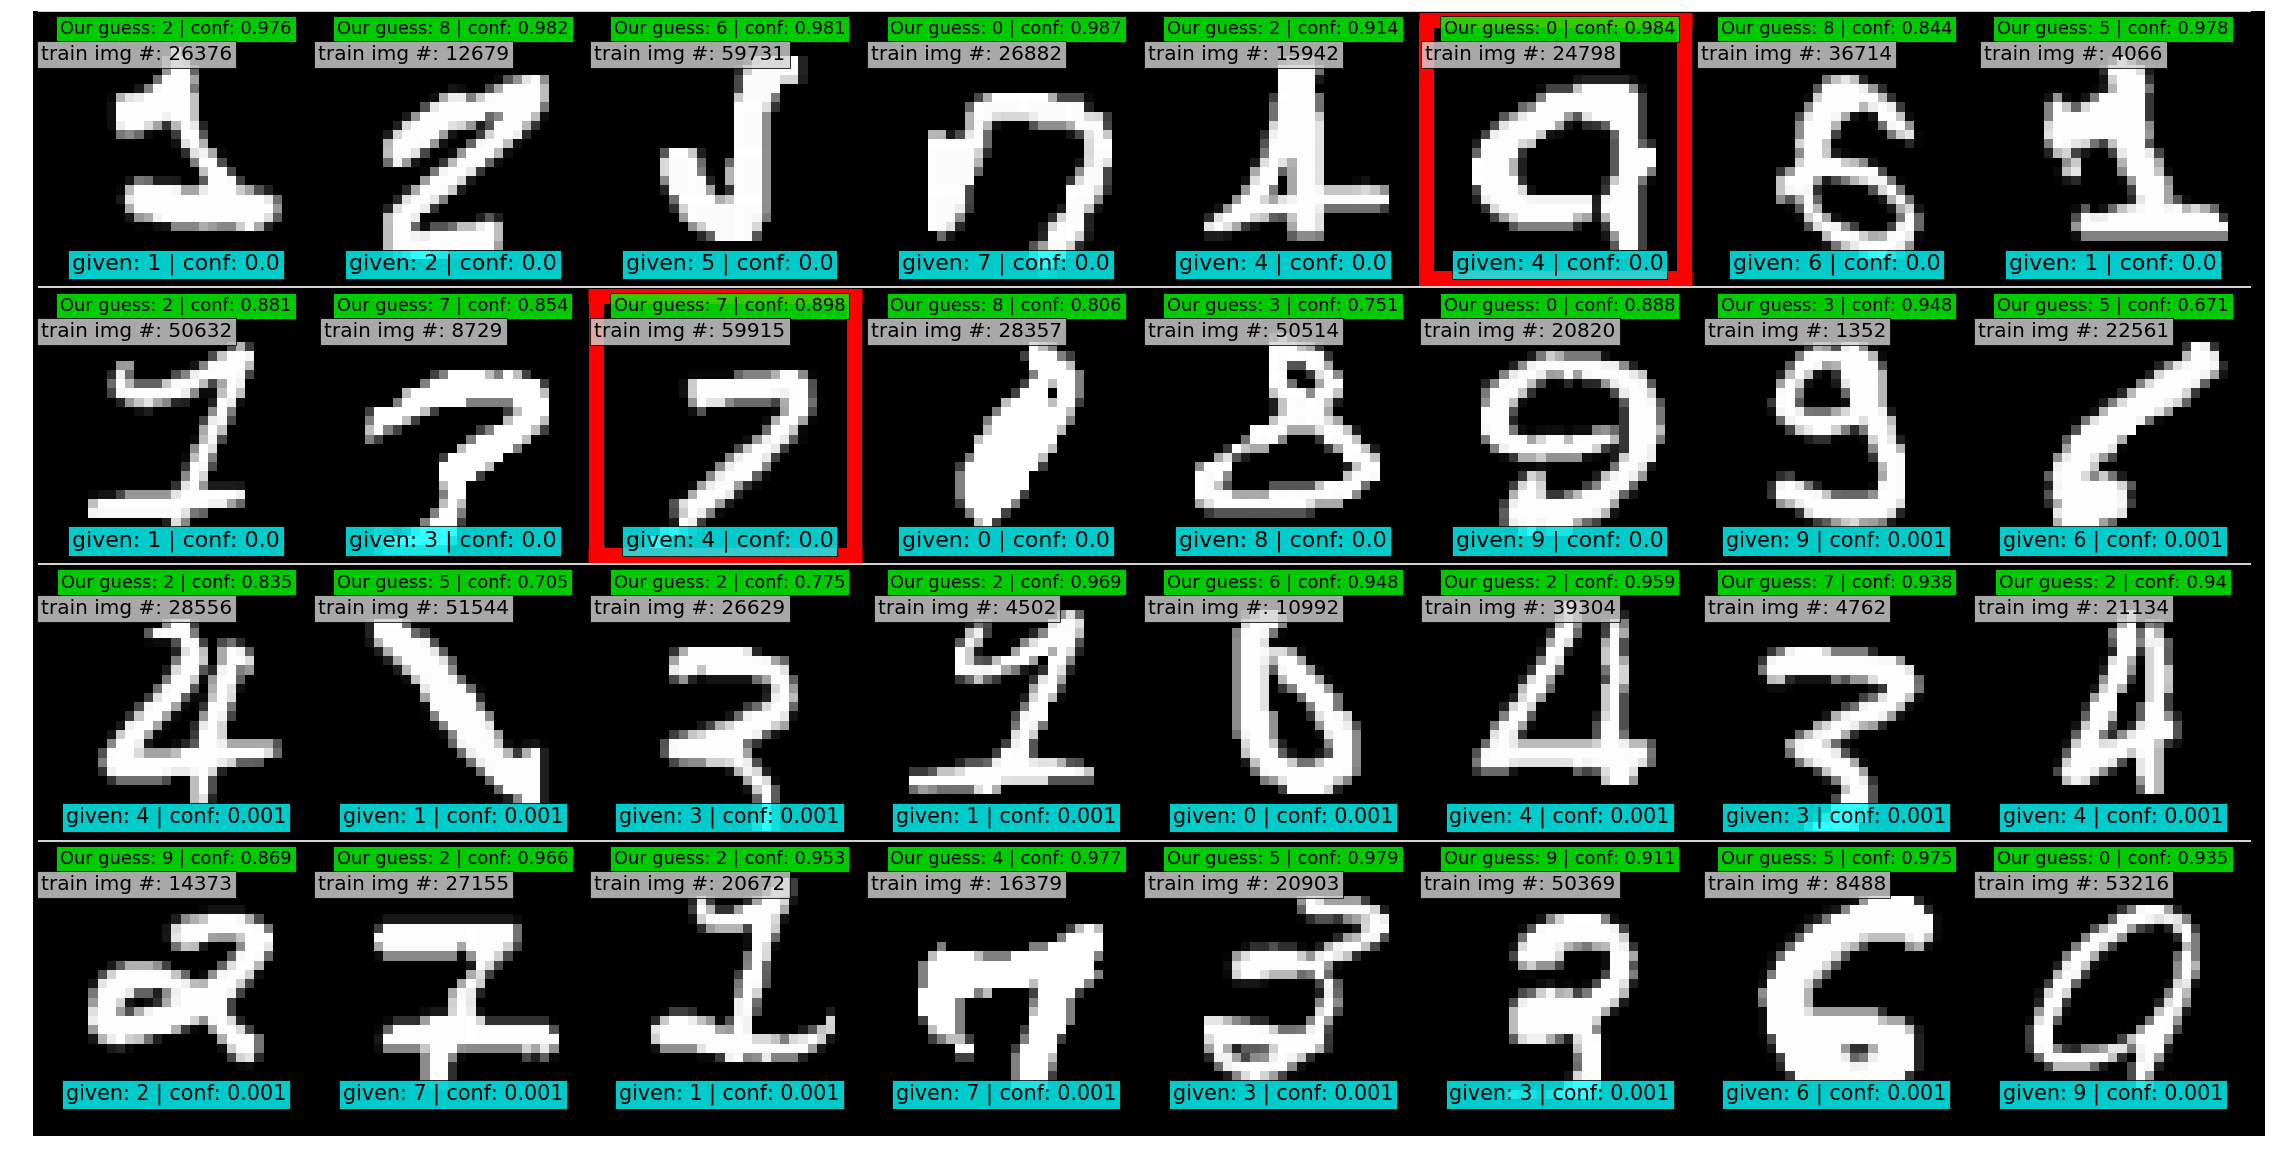

TOLERANCE 0.05 METHOD: both


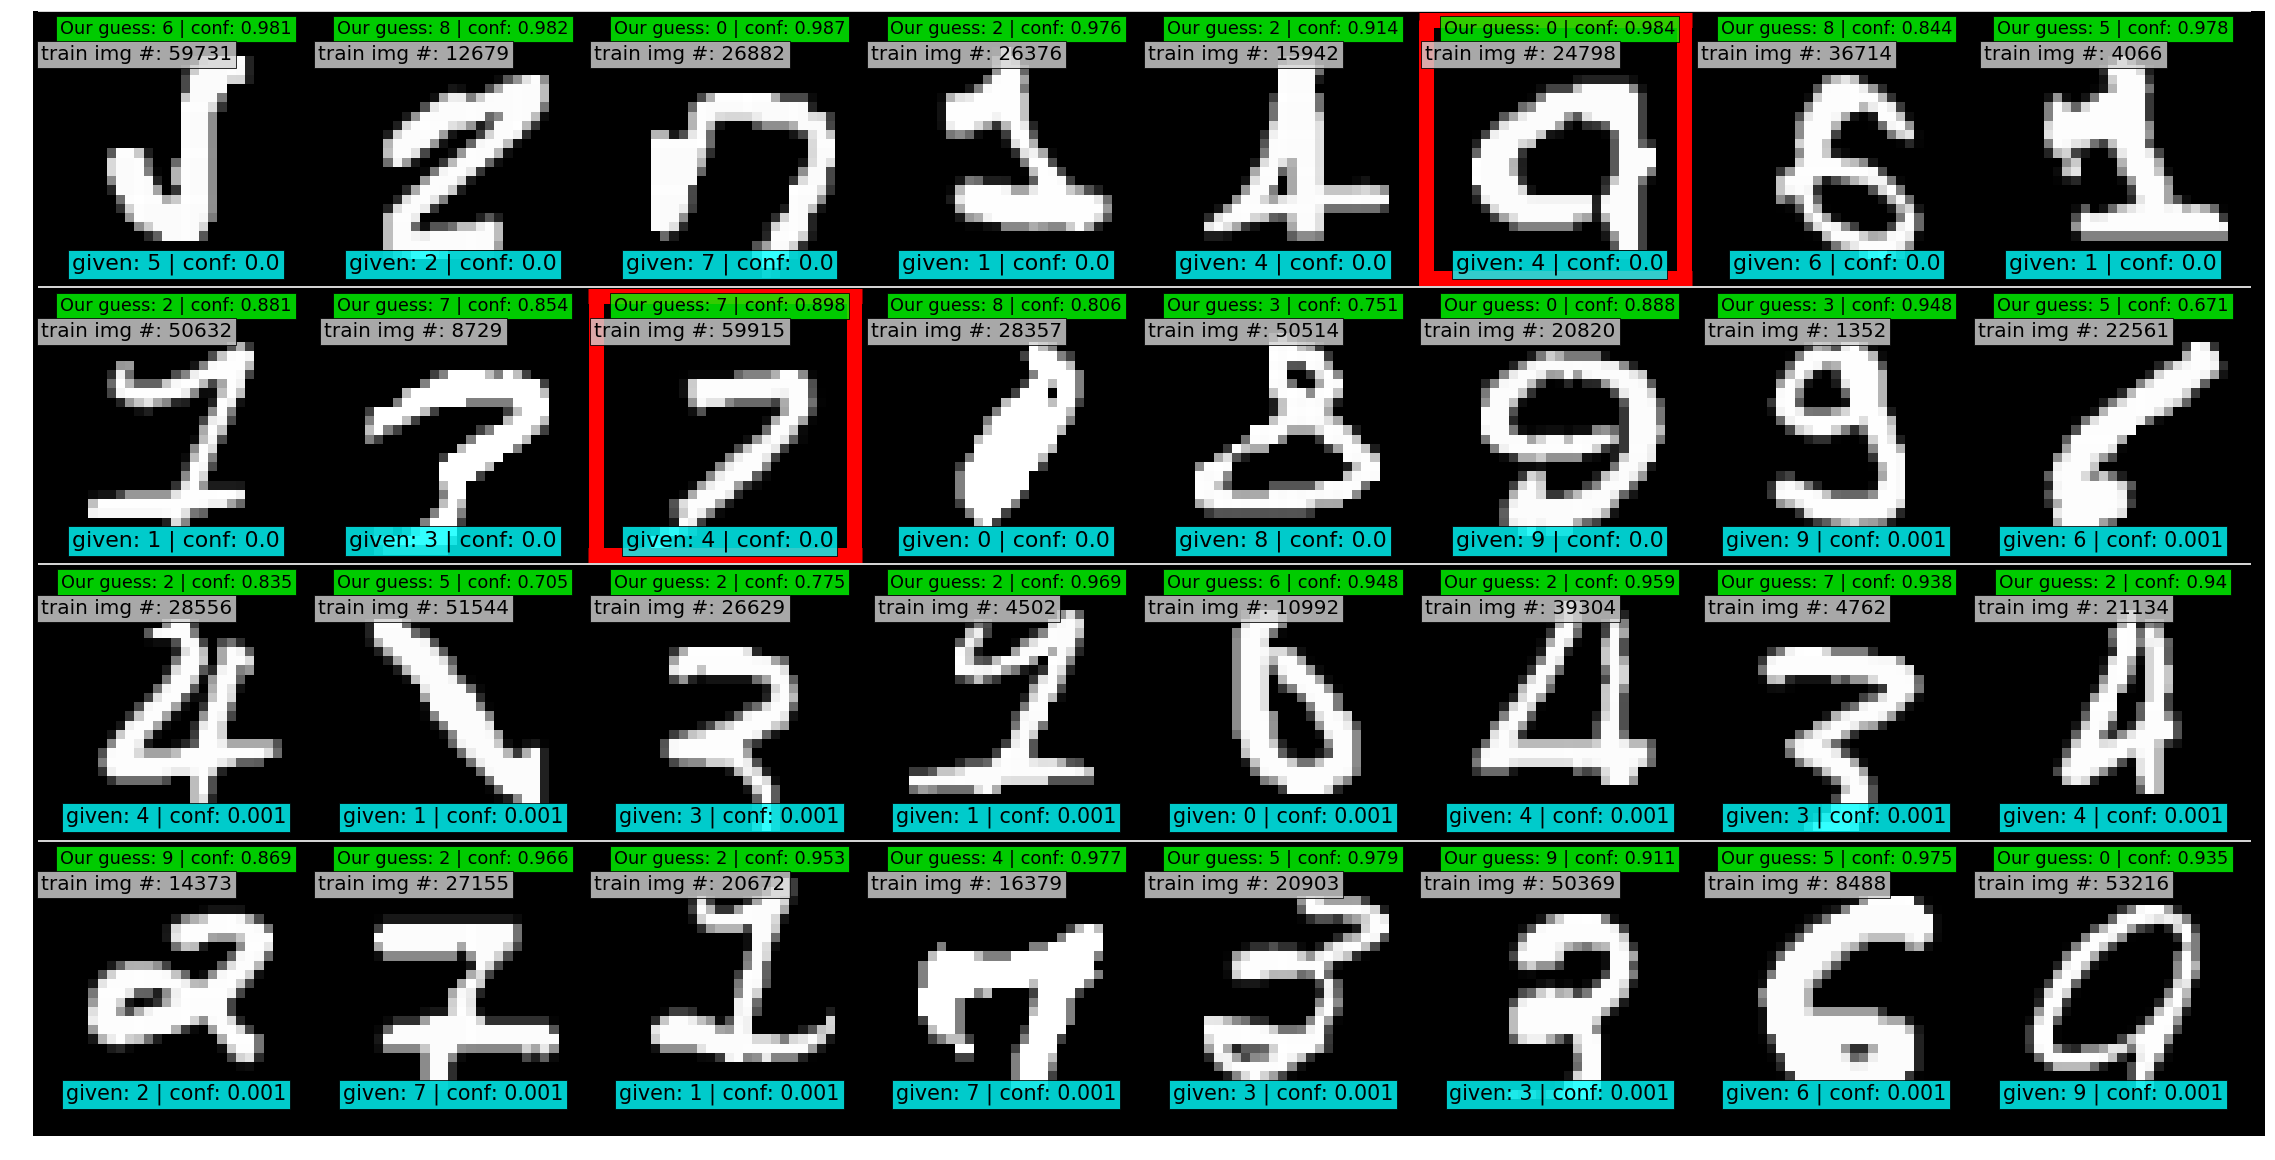

TOLERANCE 0.01 METHOD: prune_by_class


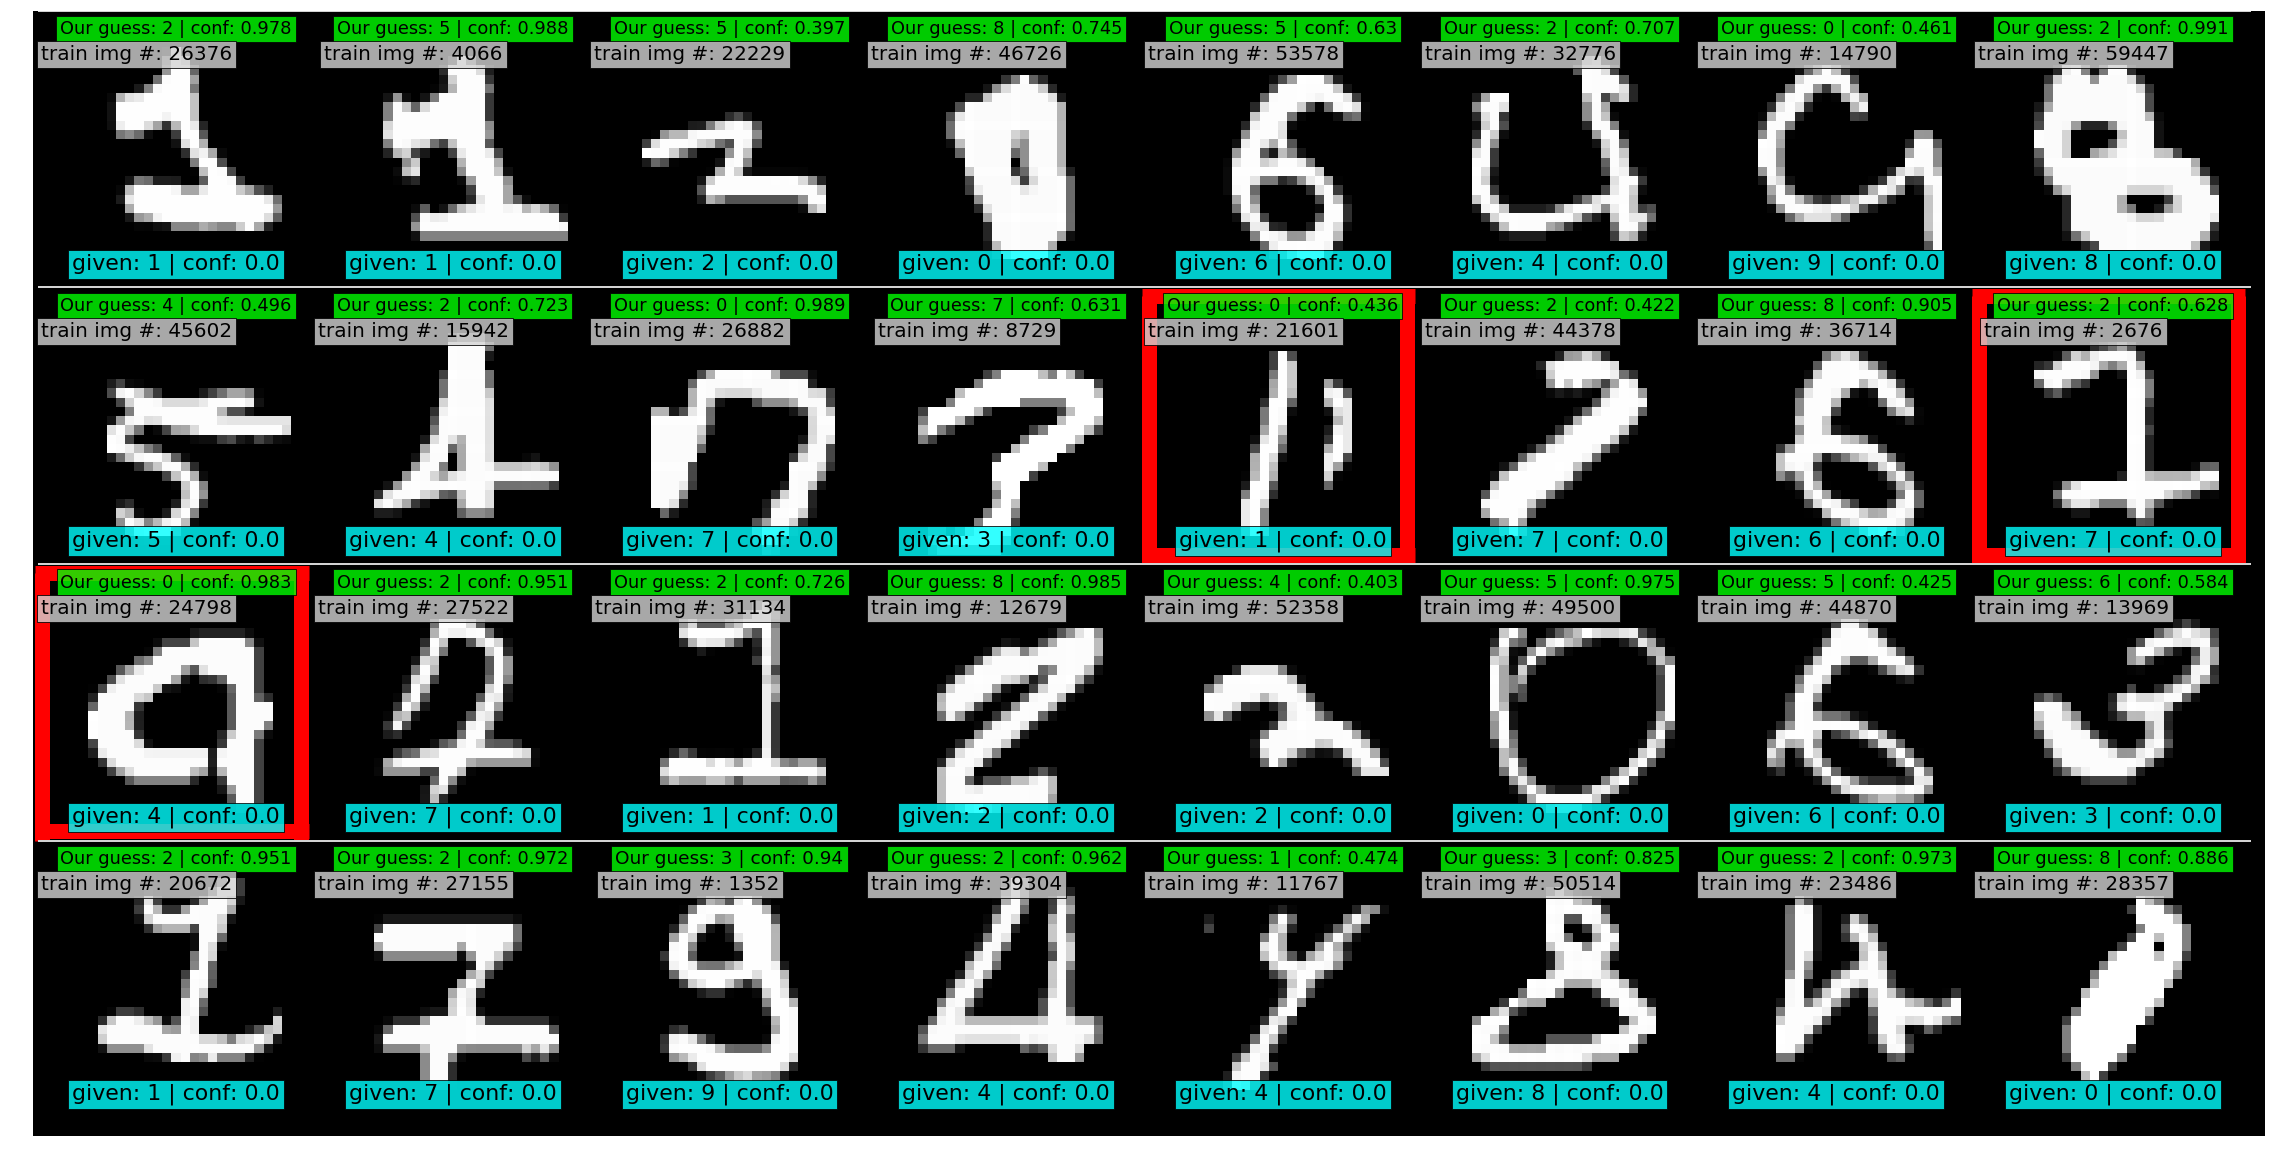

TOLERANCE 0.01 METHOD: prune_by_noise_rate


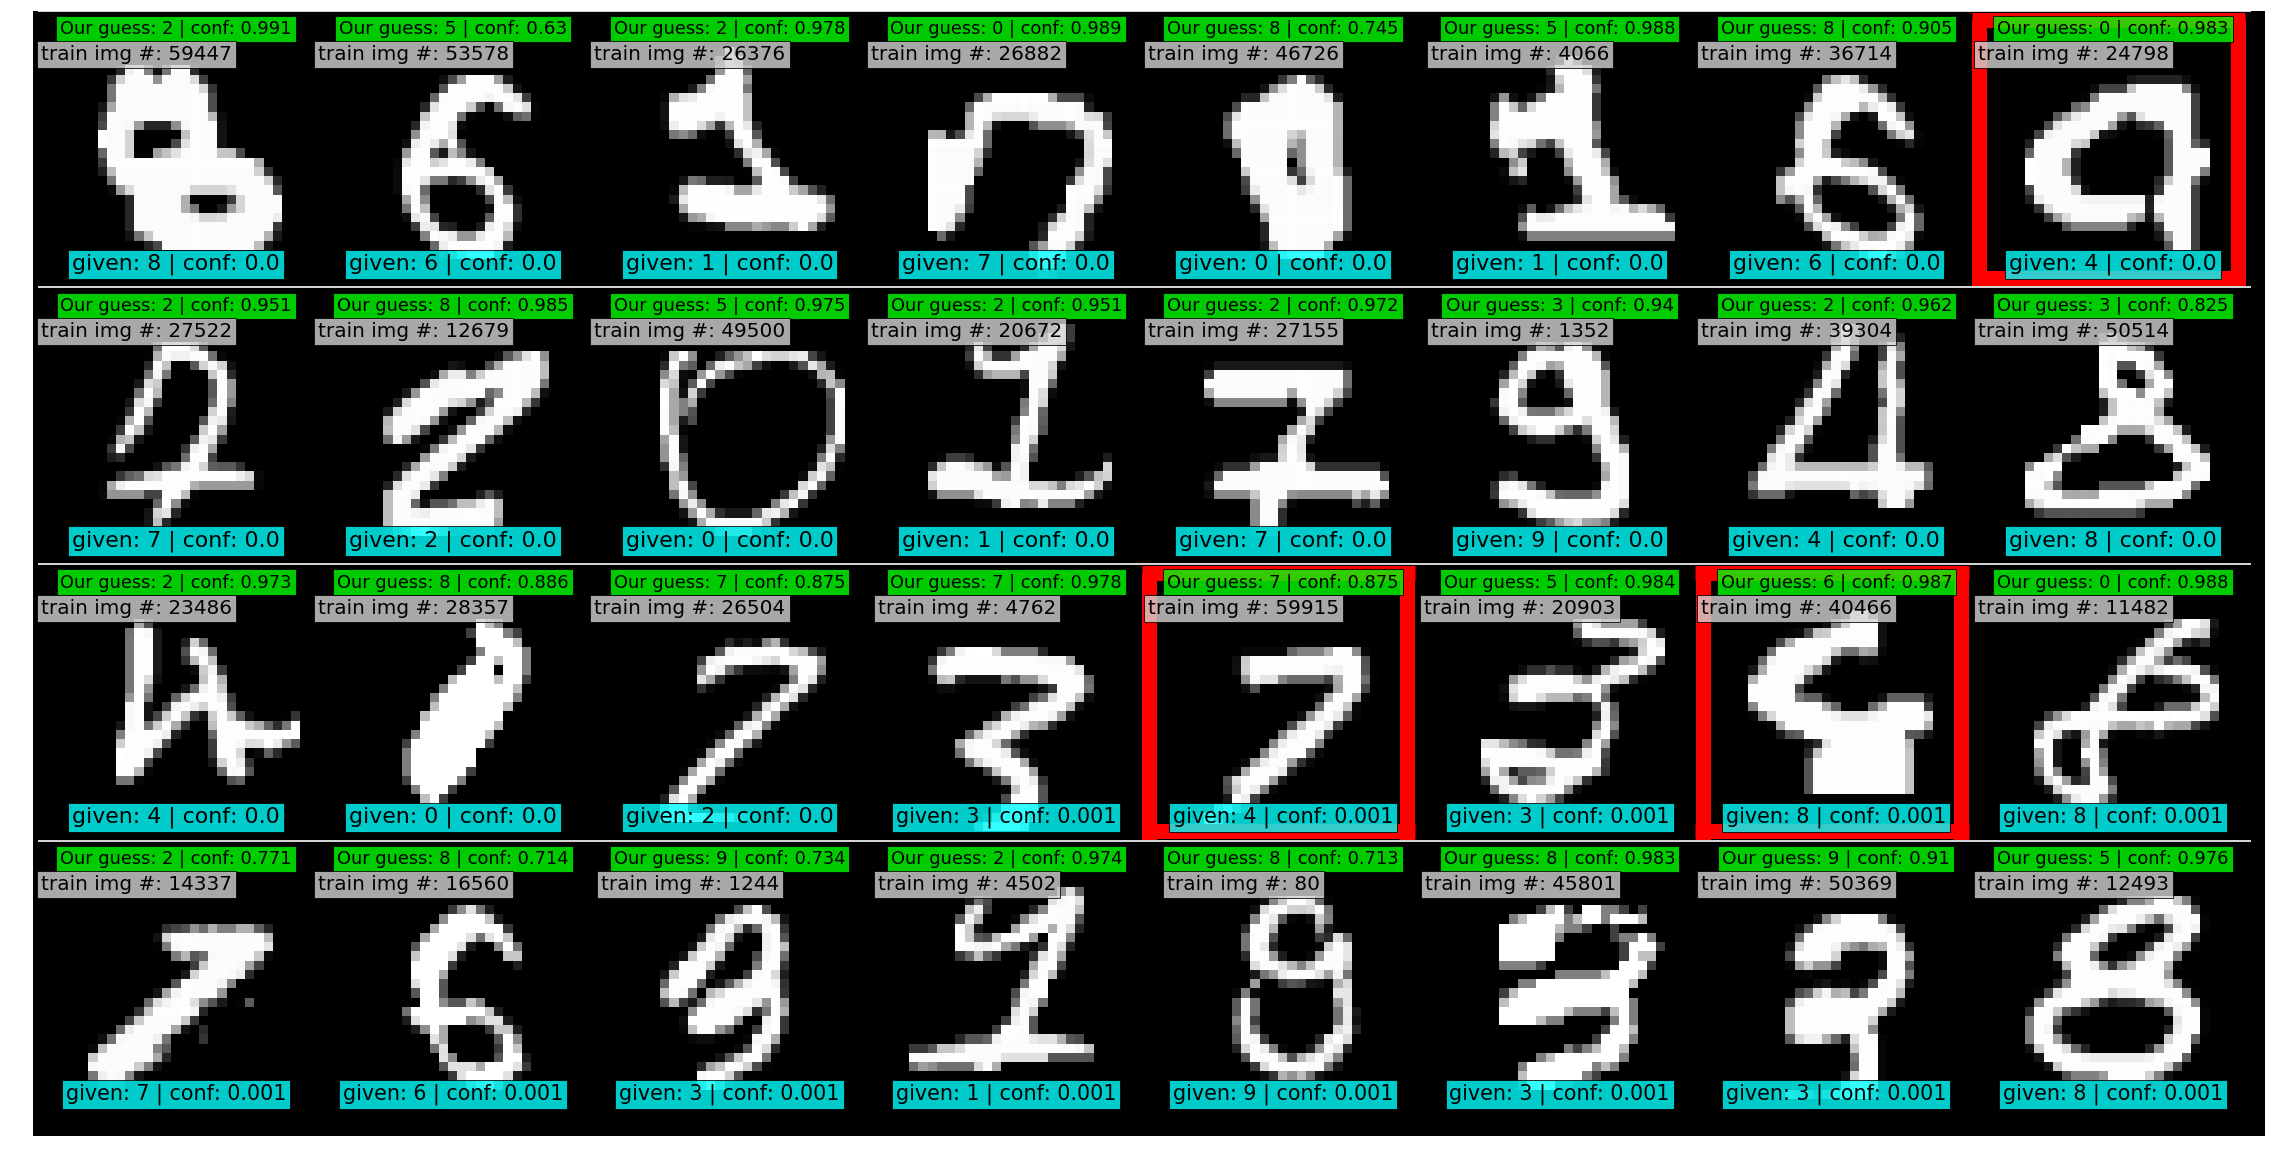

TOLERANCE 0.01 METHOD: both


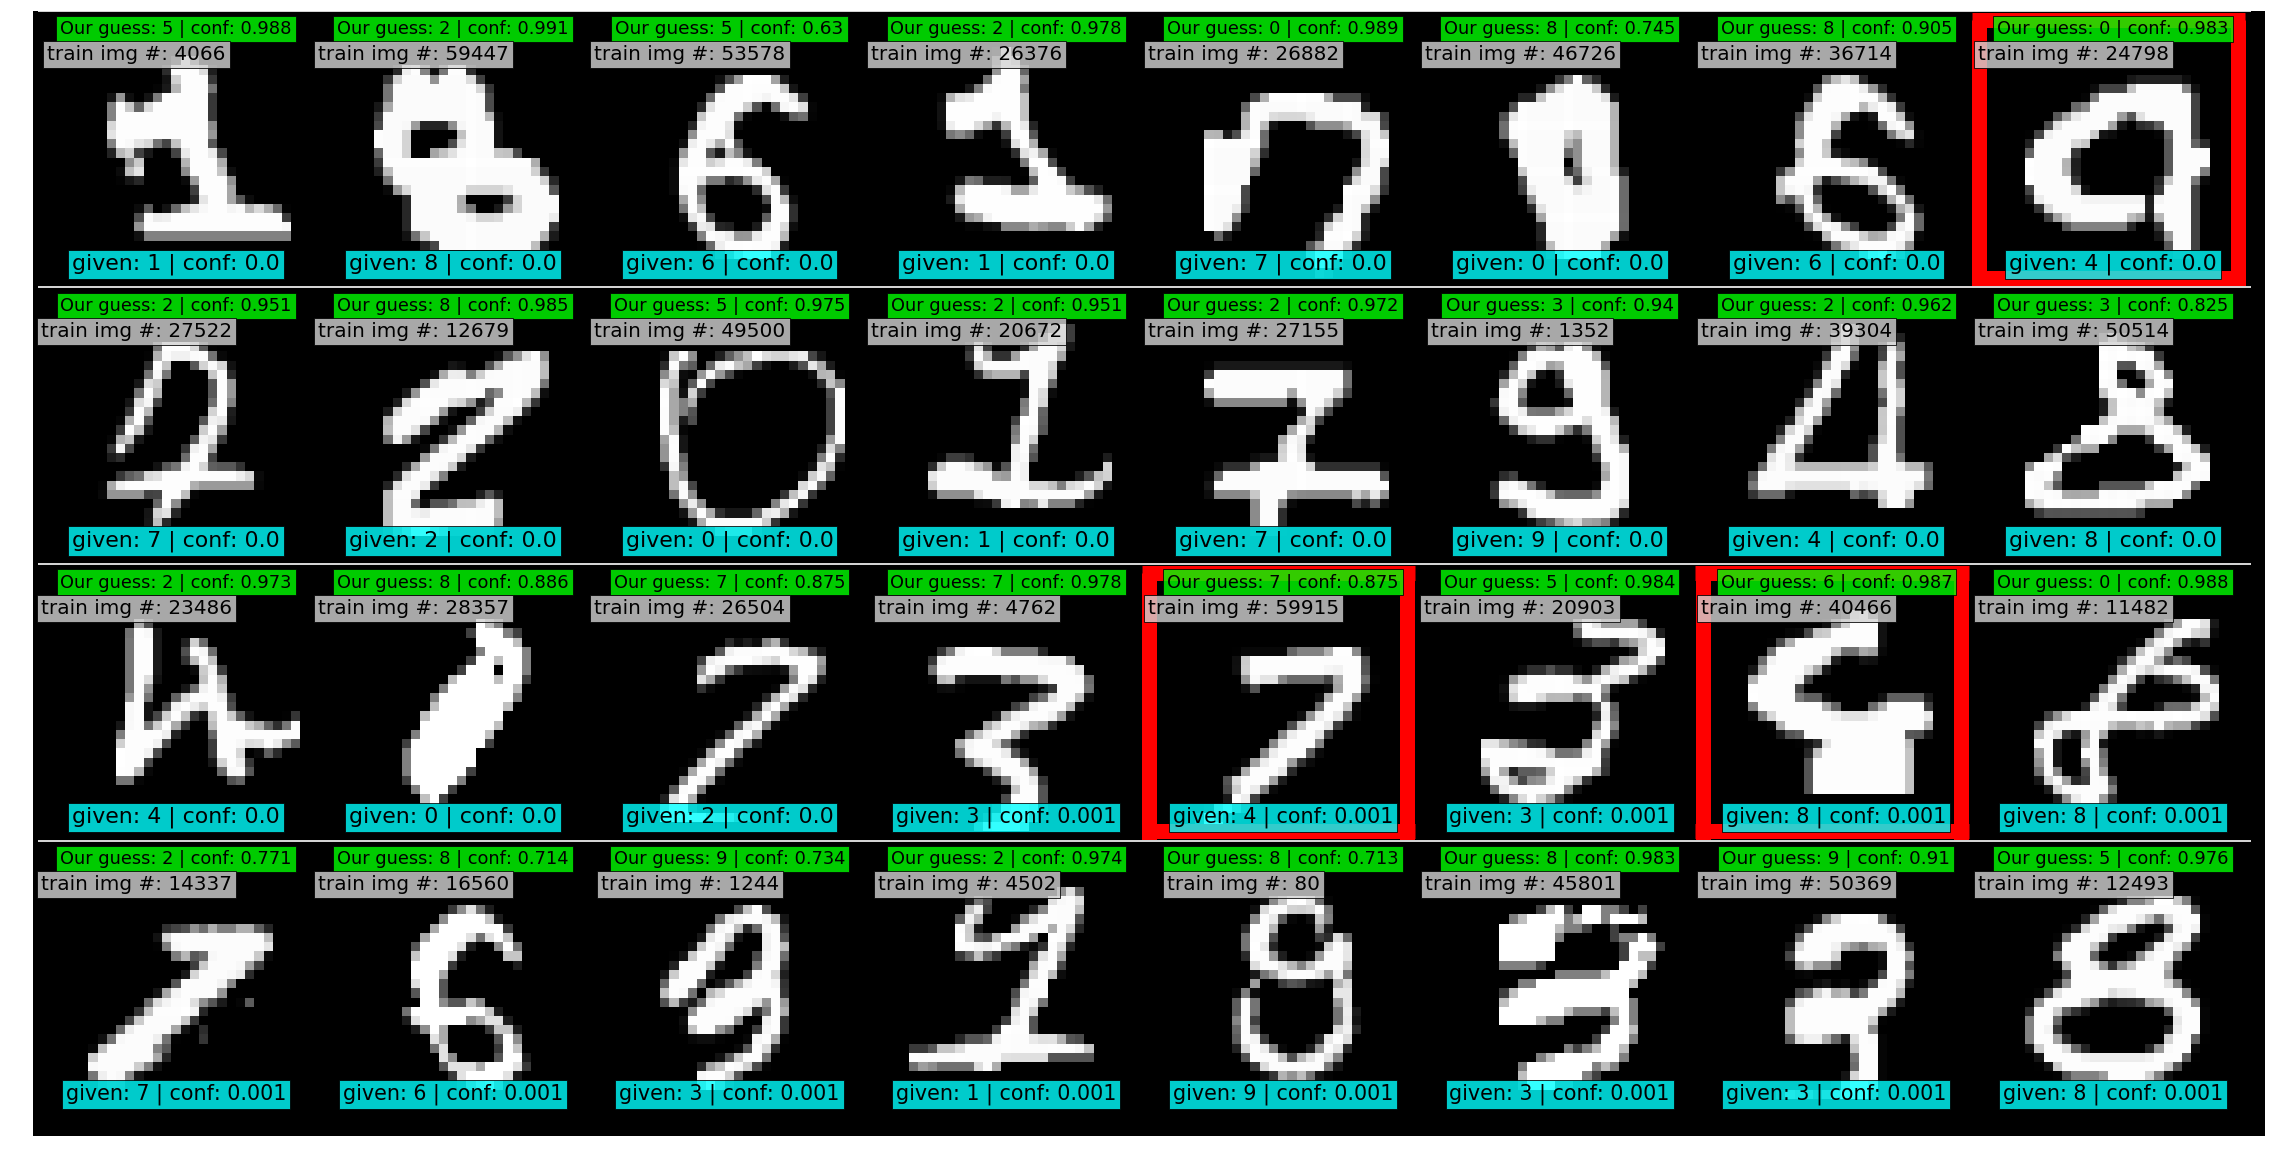

In [5]:
max_images = 32

for tolerance in [10,5,1,0.5,0.1, 0.05, 0.01]:
    clf = CalibratedClassifierCV(lr(tol=tolerance), method='isotonic', cv=5)
    jc, psx = multiclass_rankpruning.estimate_joint_counts_and_cv_pred_proba(
        X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), # Make MNIST (60000, 784)
        y_train, 
        clf=clf, 
    )
    est_py, est_nm, est_inv = multiclass_rankpruning.estimate_latent(jc, y_train)
    
    for method in ['prune_by_class', 'prune_by_noise_rate', 'both']:
        print('TOLERANCE', tolerance, 'METHOD:', method)

        noise_idx = multiclass_rankpruning.get_noise_indices(y_train, psx, est_inv, method=method, joint_count=jc)
        pred = np.argmax(psx, axis=1)
        # ordered_noise_idx = np.argsort(np.asarray([psx[idx,y_train[idx]] - psx[idx,pred[idx]] for idx in range(len(y_train)) ])[noise_idx])
        ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])

        prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
        prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
        img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
        label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
        pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

        graphic = torchvision.utils.make_grid(torch.from_numpy(np.concatenate([X_train[img_idx][:, None]]*3, axis=1)))
        # graphic = np.concatenate([graphic[:, None]]*3, axis=1)
        img_labels = ["given: "+str(label4viz[w])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
        img_pred = ["Our guess: "+str(pred4viz[w])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]
        img_fns = ["train img #: " + str(item) for item in img_idx]

        imshow(graphic, img_labels = img_labels, img_pred = img_pred, img_fns = img_fns, figsize=(40,max_images/1.1), method_name = method, savefig = False)
